In [34]:
import numpy as np
import pandas as pd
from scipy import stats
from statsmodels.stats.power import TTestIndPower

# ─── USER‐DEFINED CONSTANTS ──────────────────────────────────────────────────
FEATURES = [
    "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
    "Vertical Bin Fixation Variance_kurtosis", "Saccade Amplitude_std", 
    "Attentional Span Width_mean", "Expected Fixation Duration_std", "Word Frequency Scaling Factor_std", 'Lexical Activation Rate_mean',
     "Total Reading Time",'Gaze Duration',
    "Saccade Velocity Variability_skew", "Max Dwell Time_median",
    "Intra-Bin Transition Probability_mean", 

#‘KL Divergence’,Regression Transition Ratio, Sliding-window Transition Entropy, Word Difficulty Sensitivity

]
GROUPS = {
    "Markov": [
        "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
        "Vertical Bin Fixation Variance_kurtosis", "Intra-Bin Transition Probability_mean", "Max Dwell Time_median",
         
    ],
    "SWIFT": ["Attentional Span Width_mean", "Expected Fixation Duration_std", "Word Frequency Scaling Factor_std", 'Lexical Activation Rate_mean'],
    "Complementary": [
         "Total Reading Time",'Gaze Duration',
        "Saccade Velocity Variability_skew",
        "Saccade Amplitude_std", 
    ],
}
N1 = N2 = 50       # ADHD vs. TD
ALPHA = 0.05
POWER_ANALYSIS = TTestIndPower()


# ─── EFFECT SIZE & POWER FUNCTIONS ────────────────────────────────────────────
def cohens_d(x1, x2):
    """
    Compute Cohen's d for two independent samples x1, x2.
    Uses pooled standard deviation.
    """
    n1, n2 = len(x1), len(x2)
    m1, m2 = np.mean(x1), np.mean(x2)
    s1, s2 = np.var(x1, ddof=1), np.var(x2, ddof=1)
    # pooled standard deviation
    s_pooled = np.sqrt(((n1-1)*s1 + (n2-1)*s2) / (n1 + n2 - 2))
    return (m1 - m2) / s_pooled


def analyze_effects_and_power(df):
    results = []

    for feat in FEATURES:
        a = df.loc[df.Group == "ADHD", feat].dropna().values
        t = df.loc[df.Group == "TD",   feat].dropna().values

        d = cohens_d(a, t)
        # achieved power with n1=n2=50
        power = POWER_ANALYSIS.power(
            effect_size=abs(d),
            nobs1=N1,
            ratio=N2/N1,
            alpha=ALPHA
        )
        # required n per group for 80% power
        n_req = POWER_ANALYSIS.solve_power(
            effect_size=abs(d),
            power=0.8,
            alpha=ALPHA,
            ratio=1.0
        )

        results.append({
            "Feature": feat,
            "Cohen_d": d,
            "Power (n=50/50)": power,
            "n_per_group_for_80%": n_req
        })

    # now group‐level composites
    for grp_name, feats in GROUPS.items():
        # average across features in the group to get a composite score
        a_comp = df.loc[df.Group == "ADHD", feats].mean(axis=1).dropna().values
        t_comp = df.loc[df.Group == "TD",   feats].mean(axis=1).dropna().values

        d = cohens_d(a_comp, t_comp)
        power = POWER_ANALYSIS.power(abs(d), N1, N2/N1, ALPHA)
        n_req = POWER_ANALYSIS.solve_power(effect_size=abs(d), power=0.8, alpha=ALPHA, ratio=1.0)

        results.append({
            "Feature": grp_name + " (composite)",
            "Cohen_d": d,
            "Power (n=50/50)": power,
            "n_per_group_for_80%": n_req
        })

    return pd.DataFrame(results)


# ─── USAGE ────────────────────────────────────────────────────────────────────
if __name__ == "__main__":
    # assume df is already loaded:
    # df = pd.read_csv("path_to_your_data.csv")
    # and df.Group contains exactly "ADHD" or "TD"
    df = pd.read_csv(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/"
    "new_version03/merged_output100.csv")  # adjust path as needed

    df_results = analyze_effects_and_power(df)
    print(df_results.to_string(index=False, float_format="%.3f"))


                                Feature  Cohen_d  Power (n=50/50)  n_per_group_for_80%
          Horizontal Edge Fixations_std   -0.325            0.362              149.865
            State_Occupancy_Entropy_std    0.326            0.366              148.353
Vertical Bin Fixation Variance_kurtosis    0.185            0.150              461.109
                  Saccade Amplitude_std    0.159            0.123              623.669
            Attentional Span Width_mean   -0.056            0.059             5015.086
         Expected Fixation Duration_std   -0.328            0.368              147.070
      Word Frequency Scaling Factor_std   -0.088            0.072             2040.725
           Lexical Activation Rate_mean   -0.317            0.349              156.970
                     Total Reading Time    0.315            0.345              158.782
                          Gaze Duration    0.190            0.156              433.897
      Saccade Velocity Variability_skew    

2025-05-10 00:51:50,257 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-10 00:51:50,297 INFO Dataset size: 100 samples, 13 features
2025-05-10 00:51:50,300 INFO Class distribution:
Group
ADHD    50
TD      50
2025-05-10 00:51:50,301 INFO Missing per feature:
Horizontal Edge Fixations_std              0
State_Occupancy_Entropy_std                0
Vertical Bin Fixation Variance_kurtosis    0
Saccade Amplitude_std                      0
Attentional Span Width_mean                0
Expected Fixation Duration_std             0
Word Frequency Scaling Factor_std          0
Lexical Activation Rate_mean               0
Total Reading Time                         0
Gaze Duration                              0
Saccade Velocity Variability_skew          0
Max Dwell Time_median                      0
Intra-Bin Transition Probability_mean      0
2025-05-10 00:51:50,305 INFO Missing percentages:
Horizontal Edge Fixations_std

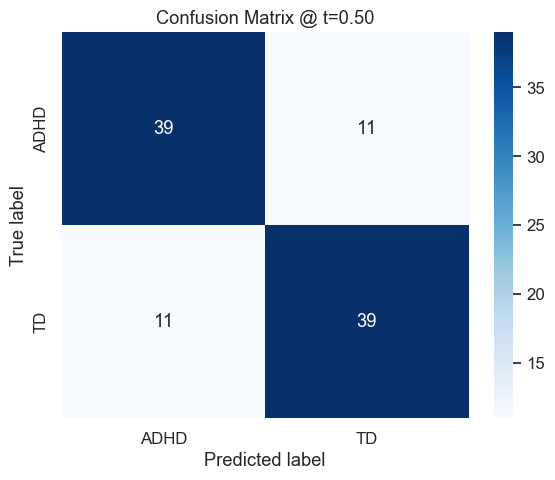

2025-05-10 00:51:59,926 INFO Final grid parameters: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
2025-05-10 00:52:06,848 INFO Completed permutation bootstraps for fold 1
2025-05-10 00:52:13,683 INFO Completed permutation bootstraps for fold 2
2025-05-10 00:52:20,800 INFO Completed permutation bootstraps for fold 3
2025-05-10 00:52:27,775 INFO Completed permutation bootstraps for fold 4
2025-05-10 00:52:34,724 INFO Completed permutation bootstraps for fold 5
2025-05-10 00:52:34,728 INFO Feature‐level ΔAUC (mean ± 95%% CI):
2025-05-10 00:52:34,729 INFO   State_Occupancy_Entropy_std     0.062 [-0.032,  0.170]
2025-05-10 00:52:34,730 INFO   Intra-Bin Transition Probability_mean  0.030 [-0.060,  0.152]
2025-05-10 00:52:34,730 INFO   Saccade Velocity Variability_skew  0.025 [-0.090,  0.174]
2025-05-10 00:52:34,731 INFO   Vertical Bin Fixation Variance_kurtosis  0.018 [-0.070,  0.118]
2025-05-10 00:52:34,732 INFO   Horizontal Edge Fixations_std   0.016 [-0.090,  0.122]
2025

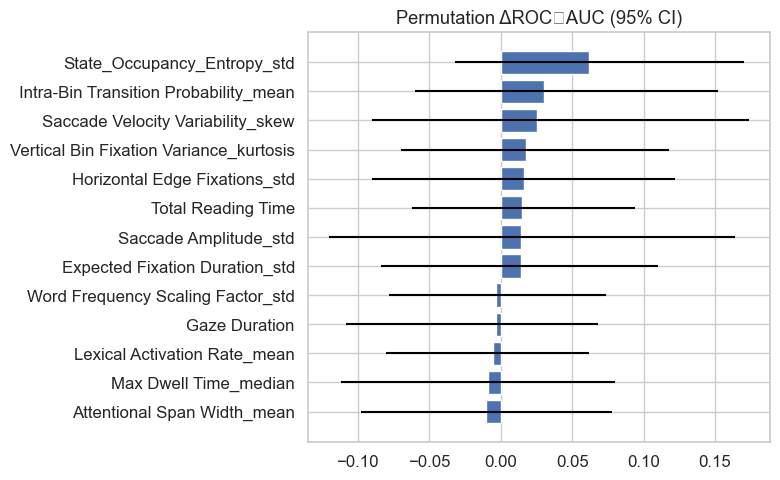

2025-05-10 00:52:35,243 INFO Computing SHAP importances (this may take a while)…


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 00:52:35,269 INFO num_full_subsets = 1
2025-05-10 00:52:35,270 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 00:52:35,271 INFO num_paired_subset_sizes = 6
2025-05-10 00:52:35,277 INFO weight_left = 0.6508991990327944
2025-05-10 00:52:35,303 INFO np.sum(w_aug) = 13.000000000000004
2025-05-10 00:52:35,316 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 00:52:35,322 INFO phi = array([-0.10452884,  0.16977903, -0.03653524, -0.01556089,  0.02935117,
        0.        , -0.33801343,  0.10272668,  0.03812242,  0.        ,
       -0.08750889,  0.02414894,  0.        ])
2025-05-10 00:52:35,328 INFO num_full_subsets = 1
2025-05-10 00:52:35,329 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 00:52:35,329 INFO num_paired_subset_sizes = 6
2025-05-10 00:52:35,339 INFO weight_left = 0.6508991990327944
2025-05-10 00:52:35,393 INFO np.sum(w_aug) = 13.000000000000004


In [35]:
#!/usr/bin/env python3
import argparse
import logging
import warnings
from pathlib import Path

import joblib
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_curve,
    auc,
    classification_report,
    confusion_matrix,
)
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# -----------------------------------------------------------------------------

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

logging.basicConfig(
    level=logging.INFO,
    format="%(asctime)s %(levelname)s %(message)s",
)
log = logging.getLogger(__name__)

DATA_PATH = Path(
    r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/"
    "new_version03/merged_output100.csv"
)
FEATURES = [
  "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
    "Vertical Bin Fixation Variance_kurtosis", "Saccade Amplitude_std", 
    "Attentional Span Width_mean", "Expected Fixation Duration_std", "Word Frequency Scaling Factor_std", 'Lexical Activation Rate_mean',
     "Total Reading Time",'Gaze Duration',
    "Saccade Velocity Variability_skew", "Max Dwell Time_median",
    "Intra-Bin Transition Probability_mean", 

#‘KL Divergence’,Regression Transition Ratio, Sliding-window Transition Entropy, Word Difficulty Sensitivity

]
GROUPS = {
    "Markov": [
        "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
        "Vertical Bin Fixation Variance_kurtosis", "Intra-Bin Transition Probability_mean", "Max Dwell Time_median",
         
    ],
    "SWIFT": ["Attentional Span Width_mean", "Expected Fixation Duration_std", "Word Frequency Scaling Factor_std", 'Lexical Activation Rate_mean'],
    "Complementary": [
         "Total Reading Time",'Gaze Duration',
        "Saccade Velocity Variability_skew",
        "Saccade Amplitude_std", 
    ],
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_full_accuracy_tuned.pkl"


def summarize_data(df: pd.DataFrame, features: list[str], target: str, le: LabelEncoder) -> None:
    """Log basic dataset statistics."""
    log.info("Dataset size: %d samples, %d features", df.shape[0], len(features))
    log.info("Class distribution:\n%s", df[target].value_counts().to_string())
    missing = df[features].isna().sum()
    log.info("Missing per feature:\n%s", missing.to_string())
    missing_pct = df[features].isna().mean() * 100
    log.info("Missing percentages:\n%s", missing_pct.to_string())
    log.info("Label mapping: %s", dict(enumerate(le.classes_)))


def load_df(path: Path) -> pd.DataFrame:
    """Load CSV and verify required columns exist."""
    log.info("Loading data from %s", path)
    if not path.exists():
        raise FileNotFoundError(f"Data file not found: {path}")
    df = pd.read_csv(path)
    missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns in CSV: {missing}")
    return df


def build_pipeline(with_smote: bool = True) -> Pipeline:
    """Construct preprocessing + (optional) SMOTE + SVM pipeline."""
    steps = [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
    ]
    if with_smote:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(
        (
            "clf",
            SVC(
                probability=True,
                class_weight="balanced",
                random_state=RANDOM_STATE,
            ),
        )
    )
    return Pipeline(steps)


def nested_cv_evaluate(
    X: np.ndarray, y: np.ndarray, le: LabelEncoder
) -> tuple[Pipeline, float]:
    """
    Perform nested cross-validation with grid search,
    report AUCs, and return best estimator + fixed threshold.
    """
    outer_cv = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner_cv = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)

    param_grid = {
        "clf__kernel": ["linear", "rbf"],
        "clf__C": [0.1, 1, 10, 100],
        "clf__gamma": ["scale", "auto"],
    }
    grid = GridSearchCV(
        build_pipeline(),
        param_grid,
        scoring="accuracy",
        cv=inner_cv,
        n_jobs=-1,
        refit=True,
    )

    all_probs = np.zeros(len(y))
    aucs = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        grid.fit(X[train_idx], y[train_idx])
        best_pipe = grid.best_estimator_
        probs = best_pipe.predict_proba(X[test_idx])[:, 1]
        all_probs[test_idx] = probs

        fpr, tpr, _ = roc_curve(y[test_idx], probs)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        log.info("Fold %d AUC = %.3f", fold, fold_auc)

    mean_auc = np.mean(aucs)
    ci_low, ci_high = np.percentile(aucs, [2.5, 97.5])
    log.info("Nested CV AUC = %.3f (95%% CI [%.3f, %.3f])", mean_auc, ci_low, ci_high)

    threshold = 0.5
    log.info("Using fixed decision threshold = %.2f", threshold)
    preds = (all_probs >= threshold).astype(int)

    report = classification_report(y, preds, target_names=le.classes_)
    log.info("Classification Report:\n%s", report)

    cm = confusion_matrix(y, preds)
    tn, fp, fn, tp = cm.ravel()
    sensitivity = tp / (tp + fn)
    specificity = tn / (tn + fp)
    log.info("Sensitivity = %.3f, Specificity = %.3f", sensitivity, specificity)

    plt.figure(figsize=(6, 5))
    sns.heatmap(
        cm,
        annot=True,
        fmt="d",
        cmap="Blues",
        xticklabels=le.classes_,
        yticklabels=le.classes_,
    )
    plt.title(f"Confusion Matrix @ t={threshold:.2f}")
    plt.ylabel("True label")
    plt.xlabel("Predicted label")
    plt.tight_layout()
    plt.show()

    # Refit on all data for final model
    grid.fit(X, y)
    log.info("Final grid parameters: %s", grid.best_params_)

    return grid.best_estimator_, threshold


def compute_permutation_importance(
    X: np.ndarray,
    y: np.ndarray,
    n_bootstraps: int = 200,
    alpha: float = 0.05,
    n_jobs: int = -1,
) -> None:
    """
    Bootstrapped permutation importances with 95% CIs,
    at both feature and group levels.
    """
    rng = np.random.RandomState(RANDOM_STATE)
    outer_cv = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    all_boot = []

    for fold, (train_idx, test_idx) in enumerate(outer_cv.split(X, y), start=1):
        X_tr, y_tr = X[train_idx], y[train_idx]
        X_te, y_te = X[test_idx], y[test_idx]

        seeds = rng.randint(0, 2**31 - 1, size=n_bootstraps)

        def _one_boot(seed: int) -> np.ndarray:
            rs = np.random.RandomState(seed)
            idx = rs.randint(0, len(y_tr), len(y_tr))
            pipe = build_pipeline()
            pipe.fit(X_tr[idx], y_tr[idx])
            imp = permutation_importance(
                pipe,
                X_te,
                y_te,
                n_repeats=5,
                random_state=rs,
                scoring="roc_auc",
            )
            return imp.importances_mean

        bs_results = np.vstack(
            Parallel(n_jobs=n_jobs)(
                delayed(_one_boot)(s) for s in seeds
            )
        )
        all_boot.append(bs_results)
        log.info("Completed permutation bootstraps for fold %d", fold)

    all_boot = np.vstack(all_boot)
    mean_imp = all_boot.mean(axis=0)
    lo_imp = np.percentile(all_boot, 100 * (alpha / 2), axis=0)
    hi_imp = np.percentile(all_boot, 100 * (1 - alpha / 2), axis=0)

    order = np.argsort(mean_imp)[::-1]
    log.info("Feature‐level ΔAUC (mean ± 95%% CI):")
    for i in order:
        log.info(
            "  %-30s %6.3f [%6.3f, %6.3f]",
            FEATURES[i],
            mean_imp[i],
            lo_imp[i],
            hi_imp[i],
        )

    # Group‐level
    group_imp = {}
    for name, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        group_imp[name] = all_boot[:, idxs].sum(axis=1)

    log.info("Group‐level ΔAUC (mean ± 95%% CI):")
    for name, vals in group_imp.items():
        m = vals.mean()
        lo, hi = np.percentile(vals, [100 * (alpha / 2), 100 * (1 - alpha / 2)])
        log.info("  %-15s %6.3f [%6.3f, %6.3f]", name, m, lo, hi)

    # Pairwise group differences
    log.info("95%% CI for group‐difference in ΔAUC:")
    names = list(group_imp.keys())
    for i in range(len(names)):
        for j in range(i + 1, len(names)):
            diff = group_imp[names[i]] - group_imp[names[j]]
            lo, hi = np.percentile(diff, [100 * (alpha / 2), 100 * (1 - alpha / 2)])
            log.info(
                "  %s vs %-12s [%6.3f, %6.3f]",
                names[i],
                names[j],
                lo,
                hi,
            )

    # Plot
    plt.figure(figsize=(8, 5))
    plt.barh(
        [FEATURES[i] for i in order],
        mean_imp[order],
        xerr=[mean_imp[order] - lo_imp[order], hi_imp[order] - mean_imp[order]],
        ecolor="black",
    )
    plt.gca().invert_yaxis()
    plt.title("Permutation ΔROC‐AUC (95% CI)")
    plt.tight_layout()
    plt.show()


def compute_shap_importance(
    pipeline: Pipeline,
    X: np.ndarray,
    alpha: float = 0.05,
    n_bootstraps: int = 200,
) -> None:
    """
    Bootstrapped SHAP |mean| importances with 95% CIs,
    at both feature and group levels.
    """
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    model_fn = lambda data: pipeline.predict_proba(data)[:, 1]

    explainer = shap.KernelExplainer(model_fn, bg)
    shap_vals = explainer.shap_values(X, nsamples=200)

    abs_vals = np.abs(shap_vals)
    mean_shap = abs_vals.mean(axis=0)

    # Bootstrap CIs
    bs_feat = []
    rng = np.random.RandomState(RANDOM_STATE + 1)
    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(X), len(X))
        bs_feat.append(abs_vals[idx].mean(axis=0))
    bs_feat = np.vstack(bs_feat)
    lo_feat = np.percentile(bs_feat, 100 * (alpha / 2), axis=0)
    hi_feat = np.percentile(bs_feat, 100 * (1 - alpha / 2), axis=0)

    order = np.argsort(mean_shap)[::-1]
    log.info("SHAP feature‐level |mean| (mean ± 95%% CI):")
    for i in order:
        log.info(
            "  %-30s %6.3f [%6.3f, %6.3f]",
            FEATURES[i],
            mean_shap[i],
            lo_feat[i],
            hi_feat[i],
        )

    # Group‐level
    log.info("SHAP group‐level |mean| (mean ± 95%% CI):")
    for name, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        vals = abs_vals[:, idxs].sum(axis=1)
        bs_grp = []
        for _ in range(n_bootstraps):
            idx = rng.randint(0, len(vals), len(vals))
            bs_grp.append(vals[idx].mean())
        lo, hi = np.percentile(bs_grp, [100 * (alpha / 2), 100 * (1 - alpha / 2)])
        log.info(
            "  %-15s %6.3f [%6.3f, %6.3f]",
            name,
            vals.mean(),
            lo,
            hi,
        )


def main():
    parser = argparse.ArgumentParser(
        description="Nested CV SVM + Permutation & SHAP Importances"
    )
    parser.add_argument(
        "--data-path",
        type=Path,
        default=DATA_PATH,
        help="Override for the CSV data path",
    )
    # ignore unknown flags in interactive environments (e.g. Jupyter)
    args, _ = parser.parse_known_args()

    df = load_df(args.data_path)
    le = LabelEncoder()
    X = df[FEATURES].values
    y = le.fit_transform(df[TARGET])

    summarize_data(df, FEATURES, TARGET, le)
    best_pipe, threshold = nested_cv_evaluate(X, y, le)
    compute_permutation_importance(X, y)
    log.info("Computing SHAP importances (this may take a while)…")
    compute_shap_importance(best_pipe, X)

    joblib.dump({"pipeline": best_pipe, "threshold": threshold}, OUT_MODEL)
    log.info("Saved pipeline + threshold → %s", OUT_MODEL)


if __name__ == "__main__":
    main()


In [20]:
#!/usr/bin/env python3
import argparse
import logging
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, classification_report, confusion_matrix
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import joblib
from joblib import Parallel, delayed

# -----------------------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

DATA_PATH = Path(
    r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv"
)
FEATURES = [
    "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
    "Fixation_Deviation_Variance_kurtosis_func", "mean_saccade_amplitude_std", 
    "nu_mean", "mt_std", "beta_std", 'r_mean',
     "totaltime_exp",'gazedur_exp',
    "std_saccade_velocity_skew", "Max_Dwell_Time_median",
    "Self_Transition_Ratio_Count_mean", 
]
GROUPS = {
    "Markov": [
        "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
        "Fixation_Deviation_Variance_kurtosis_func", "Self_Transition_Ratio_Count_mean", "Max_Dwell_Time_median",
         
    ],
    "SWIFT": ["nu_mean",  "mt_std", "beta_std", 'r_mean'],
    "Complementary": [
         "totaltime_exp",'gazedur_exp',
        "std_saccade_velocity_skew",
        "mean_saccade_amplitude_std",
    ],
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_full_accuracy_tuned.pkl"

# -----------------------------------------------------------------------------
def summarize_data(df, features, target, le):
    log.info("Dataset size: %d samples, %d features", df.shape[0], len(features))
    log.info("Class distribution:\n%s", df[target].value_counts().to_string())
    missing = df[features].isna().sum()
    log.info("Missing per feature:\n%s", missing.to_string())
    missing_pct = df[features].isna().mean() * 100
    log.info("Missing percentages:\n%s", missing_pct.to_string())
    log.info("Label mapping: %s", dict(enumerate(le.classes_)))

# -----------------------------------------------------------------------------
def load_df(path: Path):
    log.info("Loading data from %s", path)
    if not path.exists():
        raise FileNotFoundError(path)
    df = pd.read_csv(path)
    missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return df

# -----------------------------------------------------------------------------
def build_pipeline(with_smote=True):
    steps = [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
    ]
    if with_smote:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(("clf", SVC(probability=False,
                             class_weight="balanced",
                             random_state=RANDOM_STATE)))
    return Pipeline(steps)

# -----------------------------------------------------------------------------
def nested_cv_evaluate(X, y, le):
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        build_pipeline(), {
            "clf__kernel": ["linear"],
            "clf__C": [0.1, 1, 10, 100],
            "clf__gamma": ["scale"],
        },
        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True
    )

    all_probs = np.zeros(len(y))
    aucs = []

    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:, 1]
        all_probs[te] = probs

        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        log.info(f"Fold {fold}: AUC={fold_auc:.3f}")

    mean_auc = np.mean(aucs)
    ci_auc = np.percentile(aucs, [2.5, 97.5])
    log.info(f"Nested CV AUC: {mean_auc:.3f} (95% CI [{ci_auc[0]:.3f}, {ci_auc[1]:.3f}])")

    # fixed threshold at 0.5
    preds = (all_probs >= 0.5).astype(int)
    print("\nClassification Report (Nested CV):")
    print(classification_report(y, preds, target_names=le.classes_))

    cm = confusion_matrix(y, preds)
    tn, fp, fn, tp = cm.ravel()
    print(f"Sensitivity: {tp/(tp+fn):.3f}, Specificity: {tn/(tn+fp):.3f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion Matrix @ t=0.5")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    # retrain on full set for downstream interpretability
    grid.fit(X, y)
    return grid.best_estimator_, 0.5

# -----------------------------------------------------------------------------
def compute_permutation_importance(X, y, n_bootstraps=200, alpha=0.05, n_jobs=-1):
    rng = np.random.RandomState(RANDOM_STATE)
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    all_bs = []

    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        X_tr, y_tr = X[tr], y[tr]
        X_te, y_te = X[te], y[te]
        seeds = rng.randint(0, 2**31 - 1, size=n_bootstraps)

        def one_boot(seed):
            rs = np.random.RandomState(seed)
            idx = rs.randint(0, len(y_tr), len(y_tr))
            pipe = build_pipeline()
            pipe.fit(X_tr[idx], y_tr[idx])
            imp = permutation_importance(
                pipe, X_te, y_te,
                n_repeats=5, random_state=rs, scoring="roc_auc"
            )
            return imp.importances_mean

        bs = np.vstack(Parallel(n_jobs=n_jobs)(
            delayed(one_boot)(s) for s in seeds
        ))
        all_bs.append(bs)
        log.info(f"Completed fold {fold} permutation‐bootstrap")

    all_bs = np.vstack(all_bs)
    feat_mean = all_bs.mean(axis=0)
    feat_lo   = np.percentile(all_bs, 100*(alpha/2), axis=0)
    feat_hi   = np.percentile(all_bs, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print("\nFeature‐level ΔAUC (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{feat_lo[i]:.3f}, {feat_hi[i]:.3f}]")

    # group‐level
    group_bs = {}
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        group_bs[g] = all_bs[:, idxs].sum(axis=1)

    print("\nGroup‐level ΔAUC (mean ± 95% CI):")
    for g, vals in group_bs.items():
        m, lo, hi = vals.mean(), np.percentile(vals, 100*(alpha/2)), np.percentile(vals, 100*(1-alpha/2))
        print(f"  {g:15s}{m:.3f} [{lo:.3f}, {hi:.3f}]")

    print("\n95% CI for group‐difference in ΔAUC:")
    names = list(group_bs.keys())
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            d = group_bs[names[i]] - group_bs[names[j]]
            lo, hi = np.percentile(d, [100*(alpha/2), 100*(1-alpha/2)])
            print(f"  {names[i]} vs {names[j]:<12s}[{lo:.3f}, {hi:.3f}]")

    # plot
    plt.figure(figsize=(8, 5))
    plt.barh([FEATURES[i] for i in order], feat_mean[order],
             xerr=[feat_mean[order]-feat_lo[order],
                   feat_hi[order]-feat_mean[order]],
             ecolor="black")
    plt.gca().invert_yaxis()
    plt.title("Permutation ΔROC‐AUC (95% CI)")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------
def compute_shap_importance(pipeline, X, alpha=0.05, n_bootstraps=200):
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    explainer = shap.KernelExplainer(lambda d: pipeline.predict_proba(d)[:,1], bg)
    shap_vals = explainer.shap_values(X, nsamples=200)
    abs_shap = np.abs(shap_vals)

    feat_mean = abs_shap.mean(axis=0)
    bs_feats = []
    rng = np.random.RandomState(RANDOM_STATE+1)
    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(X), len(X))
        bs_feats.append(abs_shap[idx].mean(axis=0))
    bs_feats = np.vstack(bs_feats)
    feat_lo = np.percentile(bs_feats, 100*(alpha/2), axis=0)
    feat_hi = np.percentile(bs_feats, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print("\nSHAP feature‐level |mean| (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{feat_lo[i]:.3f}, {feat_hi[i]:.3f}]")

    # group‐level
    group_bs = {}
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        vals = abs_shap[:, idxs].sum(axis=1)
        group_bs[g] = vals

    print("\nSHAP group‐level |mean| (mean ± 95% CI):")
    for g, vals in group_bs.items():
        bs = []
        for _ in range(n_bootstraps):
            idx = rng.randint(0, len(vals), len(vals))
            bs.append(vals[idx].mean())
        lo, hi = np.percentile(bs, [100*(alpha/2), 100*(1-alpha/2)])
        print(f"  {g:15s}{vals.mean():.3f} [{lo:.3f}, {hi:.3f}]")

# -----------------------------------------------------------------------------
def main():
    parser = argparse.ArgumentParser(description="Nested CV SVM + Permutation & SHAP")
    parser.add_argument("--data-path", type=str, help="CSV path override")
    args, _ = parser.parse_known_args()

    path = Path(args.data_path) if args.data_path else DATA_PATH
    df = load_df(path)

    le = LabelEncoder()
    X = df[FEATURES].values
    y = le.fit_transform(df[TARGET])

    summarize_data(df, FEATURES, TARGET, le)
    best_pipe, thresh = nested_cv_evaluate(X, y, le)
    compute_permutation_importance(X, y)
    print("\nComputing SHAP values (this may take a minute)…")
    compute_shap_importance(best_pipe, X)

    joblib.dump({"pipeline": best_pipe, "threshold": thresh}, OUT_MODEL)
    log.info("Saved pipeline + threshold → %s", OUT_MODEL)

if __name__ == "__main__":
    main()


2025-05-09 18:52:31,433 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-09 18:52:31,453 INFO Dataset size: 100 samples, 13 features
2025-05-09 18:52:31,454 INFO Class distribution:
Group
ADHD    50
TD      50
2025-05-09 18:52:31,457 INFO Missing per feature:
Frac_Extreme_X_std                           0
State_Occupancy_Entropy_std                  0
Fixation_Deviation_Variance_kurtosis_func    0
mean_saccade_amplitude_std                   0
nu_mean                                      0
mt_std                                       0
beta_std                                     0
r_mean                                       0
totaltime_exp                                0
gazedur_exp                                  0
std_saccade_velocity_skew                    0
Max_Dwell_Time_median                        0
Self_Transition_Ratio_Count_mean             0
2025-05-09 18:52:31,461 INFO Missing percentages:
Fra

AttributeError: This 'GridSearchCV' has no attribute 'predict_proba'

2025-05-10 00:53:15,228 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-10 00:53:15,252 INFO Dataset size: 100 samples, 13 features
2025-05-10 00:53:15,254 INFO Class distribution:
Group
ADHD    50
TD      50
2025-05-10 00:53:15,256 INFO Missing per feature:
Horizontal Edge Fixations_std              0
State_Occupancy_Entropy_std                0
Vertical Bin Fixation Variance_kurtosis    0
Saccade Amplitude_std                      0
Attentional Span Width_mean                0
Expected Fixation Duration_std             0
Word Frequency Scaling Factor_std          0
Lexical Activation Rate_mean               0
Total Reading Time                         0
Gaze Duration                              0
Saccade Velocity Variability_skew          0
Max Dwell Time_median                      0
Intra-Bin Transition Probability_mean      0
2025-05-10 00:53:15,260 INFO Missing percentages:
Horizontal Edge Fixations_std


Classification Report (Nested CV):
              precision    recall  f1-score   support

        ADHD       0.78      0.78      0.78        50
          TD       0.78      0.78      0.78        50

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100

Sensitivity: 0.780, Specificity: 0.780


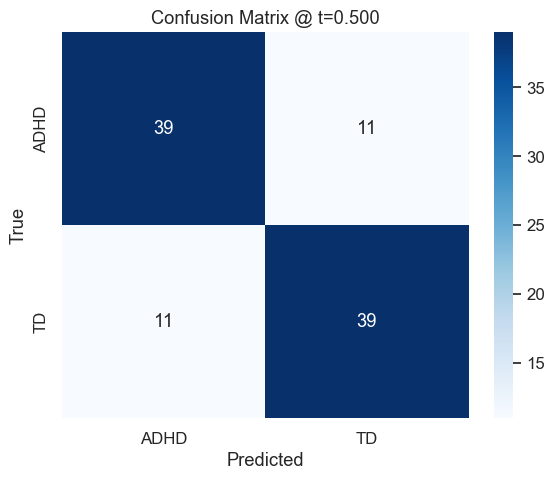

2025-05-10 00:53:20,637 INFO Final params: {'clf__C': 100, 'clf__gamma': 'scale', 'clf__kernel': 'linear'}
2025-05-10 00:53:27,604 INFO Completed fold 1 permutation bootstraps
2025-05-10 00:53:34,997 INFO Completed fold 2 permutation bootstraps
2025-05-10 00:53:42,657 INFO Completed fold 3 permutation bootstraps
2025-05-10 00:53:50,014 INFO Completed fold 4 permutation bootstraps
2025-05-10 00:53:57,240 INFO Completed fold 5 permutation bootstraps



Feature‐level ΔAUC (mean ± 95% CI):
  State_Occupancy_Entropy_std   0.062 [-0.032, 0.170]
  Intra-Bin Transition Probability_mean0.030 [-0.060, 0.152]
  Saccade Velocity Variability_skew0.025 [-0.090, 0.174]
  Vertical Bin Fixation Variance_kurtosis0.018 [-0.070, 0.118]
  Horizontal Edge Fixations_std 0.016 [-0.090, 0.122]
  Total Reading Time            0.015 [-0.062, 0.094]
  Saccade Amplitude_std         0.014 [-0.120, 0.164]
  Expected Fixation Duration_std0.014 [-0.084, 0.110]
  Word Frequency Scaling Factor_std-0.003 [-0.078, 0.074]
  Gaze Duration                 -0.003 [-0.108, 0.068]
  Lexical Activation Rate_mean  -0.006 [-0.080, 0.062]
  Max Dwell Time_median         -0.009 [-0.112, 0.080]
  Attentional Span Width_mean   -0.010 [-0.098, 0.078]

Group‐level ΔAUC (mean ± 95% CI):
  Markov         0.118 [-0.172, 0.434]
  SWIFT          -0.005 [-0.220, 0.212]
  Complementary  0.051 [-0.222, 0.318]

95% CI for group‐difference in ΔAUC:
  Markov vs SWIFT       [-0.126, 0.394]
  M

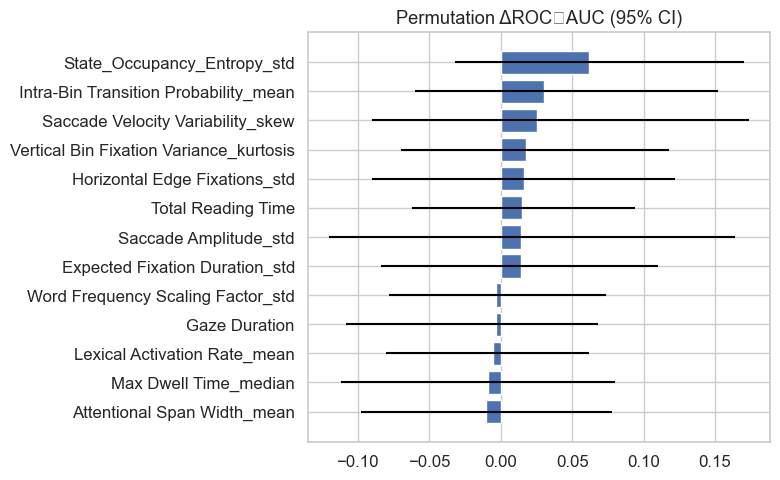

Computing SHAP values (this may take a minute)…


  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-10 00:53:57,799 INFO num_full_subsets = 1
2025-05-10 00:53:57,800 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 00:53:57,801 INFO num_paired_subset_sizes = 6
2025-05-10 00:53:57,809 INFO weight_left = 0.6508991990327944
2025-05-10 00:53:57,852 INFO np.sum(w_aug) = 13.0
2025-05-10 00:53:57,852 INFO np.sum(self.kernelWeights) = 1.0
2025-05-10 00:53:57,860 INFO phi = array([-0.10637496,  0.14630319, -0.04969619,  0.        ,  0.02242373,
       -0.04324207, -0.31955458,  0.13356923,  0.04512309,  0.        ,
       -0.08022299,  0.03365249,  0.        ])
2025-05-10 00:53:57,867 INFO num_full_subsets = 1
2025-05-10 00:53:57,869 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-10 00:53:57,872 INFO num_paired_subset_sizes = 6
2025-05-10 00:53:57,880 INFO weight_left = 0.6508991990327944
2025-05-10 00:53:57,921 INFO np.sum(w_aug) = 13.000000000000002
2025-05-10 00:


SHAP feature‐level |mean| (mean ± 95% CI):
  Total Reading Time            0.192 [0.170, 0.216]
  Gaze Duration                 0.187 [0.165, 0.215]
  Word Frequency Scaling Factor_std0.145 [0.127, 0.166]
  Lexical Activation Rate_mean  0.128 [0.112, 0.145]
  Max Dwell Time_median         0.070 [0.062, 0.079]
  Expected Fixation Duration_std0.069 [0.056, 0.081]
  State_Occupancy_Entropy_std   0.065 [0.055, 0.077]
  Horizontal Edge Fixations_std 0.063 [0.052, 0.071]
  Attentional Span Width_mean   0.051 [0.041, 0.063]
  Saccade Amplitude_std         0.049 [0.041, 0.058]
  Intra-Bin Transition Probability_mean0.045 [0.038, 0.053]
  Vertical Bin Fixation Variance_kurtosis0.045 [0.037, 0.052]
  Saccade Velocity Variability_skew0.039 [0.033, 0.047]

SHAP group‐level |mean| (mean ± 95% CI):
  Markov         0.288 [0.266, 0.311]
  SWIFT          0.393 [0.361, 0.424]
  Complementary  0.468 [0.427, 0.511]



In [36]:
import argparse
import logging
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_curve, auc,
    classification_report, confusion_matrix
)
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import joblib
from joblib import Parallel, delayed

# -----------------------------------------------------------------------------

# suppress those FutureWarnings from sklearn BaseEstimator._validate_data

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

logging.basicConfig(level=logging.INFO,
                   format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

DATA_PATH = Path(
    r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv"
)
FEATURES = [
   "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
    "Vertical Bin Fixation Variance_kurtosis", "Saccade Amplitude_std", 
    "Attentional Span Width_mean", "Expected Fixation Duration_std", "Word Frequency Scaling Factor_std", 'Lexical Activation Rate_mean',
     "Total Reading Time",'Gaze Duration',
    "Saccade Velocity Variability_skew", "Max Dwell Time_median",
    "Intra-Bin Transition Probability_mean", 

#‘KL Divergence’,Regression Transition Ratio, Sliding-window Transition Entropy, Word Difficulty Sensitivity

]
GROUPS = {
    "Markov": [
        "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
        "Vertical Bin Fixation Variance_kurtosis", "Intra-Bin Transition Probability_mean", "Max Dwell Time_median",
         
    ],
    "SWIFT": ["Attentional Span Width_mean", "Expected Fixation Duration_std", "Word Frequency Scaling Factor_std", 'Lexical Activation Rate_mean'],
    "Complementary": [
         "Total Reading Time",'Gaze Duration',
        "Saccade Velocity Variability_skew",
        "Saccade Amplitude_std", 
    ],
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_full_accuracy_tuned.pkl"

# -----------------------------------------------------------------------------

def summarize_data(df, features, target, le):
    log.info("Dataset size: %d samples, %d features", df.shape[0], len(features))
    log.info("Class distribution:\n%s", df[target].value_counts().to_string())
    missing = df[features].isna().sum()
    log.info("Missing per feature:\n%s", missing.to_string())
    missing_pct = df[features].isna().mean() * 100
    log.info("Missing percentages:\n%s", missing_pct.to_string())
    log.info("Label mapping: %s", dict(enumerate(le.classes_)))

# -----------------------------------------------------------------------------

def load_df(path: Path):
    log.info("Loading data from %s", path)
    if not path.exists():
        raise FileNotFoundError(path)
    df = pd.read_csv(path)
    missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return df

# -----------------------------------------------------------------------------

def build_pipeline(with_smote=True):
    steps = [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
    ]
    if with_smote:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(("clf", SVC(
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )))
    return Pipeline(steps)

# -----------------------------------------------------------------------------

def nested_cv_evaluate(X, y, le,
                       threshold_metric="equality",
                       threshold_weight=0.5):
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        build_pipeline(), {
            "clf__kernel": ["linear", "rbf"],
            "clf__C": [0.1, 1, 10, 100],
            "clf__gamma": ["scale", "auto"],
        },
        scoring="accuracy", cv=inner, n_jobs=-1, refit=True
    )

    all_probs = np.zeros(len(y))
    aucs = []

    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        grid.fit(X[tr], y[tr])
        pipe = grid.best_estimator_
        probs = pipe.predict_proba(X[te])[:, 1]
        all_probs[te] = probs

        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        log.info(f"Fold {fold}: AUC={fold_auc:.3f}")

    mean_auc = np.mean(aucs)
    ci_auc = np.percentile(aucs, [2.5, 97.5])
    log.info(f"Nested CV AUC: {mean_auc:.3f} (95% CI [{ci_auc[0]:.3f}, {ci_auc[1]:.3f}])")

    chosen_t = 0.5
    log.info(f"Using fixed threshold: {chosen_t:.3f}")

    preds = (all_probs >= chosen_t).astype(int)
    print("\nClassification Report (Nested CV):")
    print(classification_report(y, preds, target_names=le.classes_))

    cm = confusion_matrix(y, preds)
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    print(f"Sensitivity: {sens:.3f}, Specificity: {spec:.3f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix @ t={chosen_t:.3f}")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    grid.fit(X, y)
    log.info("Final params: %s", grid.best_params_)
    return grid.best_estimator_, chosen_t

# -----------------------------------------------------------------------------

def compute_permutation_importance(X, y,
                                   n_bootstraps=200, alpha=0.05, n_jobs=-1):
    """
    Bootstrapped, held-out permutation importances at feature and group level,
    with CIs and pairwise group‐difference CIs.
    """
    rng = np.random.RandomState(RANDOM_STATE)
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    all_bs = []  # will hold shape (n_bootstrap_tot, n_features)

    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        X_tr, y_tr = X[tr], y[tr]
        X_te, y_te = X[te], y[te]
        seeds = rng.randint(0, 2**31 - 1, size=n_bootstraps)

        def one_boot(seed):
            rs = np.random.RandomState(seed)
            idx = rs.randint(0, len(y_tr), len(y_tr))
            pipe = build_pipeline()
            pipe.fit(X_tr[idx], y_tr[idx])
            imp = permutation_importance(
                pipe, X_te, y_te, n_repeats=5,
                random_state=rs, scoring="roc_auc"
            )
            return imp.importances_mean

        bs = np.vstack(Parallel(n_jobs=n_jobs)(
            delayed(one_boot)(s) for s in seeds
        ))
        all_bs.append(bs)
        log.info(f"Completed fold {fold} permutation bootstraps")

    all_bs = np.vstack(all_bs)
    feat_mean = all_bs.mean(axis=0)
    feat_lo = np.percentile(all_bs, 100*(alpha/2), axis=0)
    feat_hi = np.percentile(all_bs, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print(f"\nFeature‐level ΔAUC (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{feat_lo[i]:.3f}, {feat_hi[i]:.3f}]")

    # group‐level
    group_bs = {}
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        group_bs[g] = all_bs[:, idxs].sum(axis=1)

    print(f"\nGroup‐level ΔAUC (mean ± 95% CI):")
    for g, vals in group_bs.items():
        m, lo, hi = vals.mean(), np.percentile(vals, 100*(alpha/2)), np.percentile(vals, 100*(1-alpha/2))
        print(f"  {g:15s}{m:.3f} [{lo:.3f}, {hi:.3f}]")

    # pairwise differences
    print(f"\n95% CI for group‐difference in ΔAUC:")
    names = list(group_bs.keys())
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            d = group_bs[names[i]] - group_bs[names[j]]
            lo, hi = np.percentile(d, [100*(alpha/2), 100*(1-alpha/2)])
            print(f"  {names[i]} vs {names[j]:<12s}[{lo:.3f}, {hi:.3f}]")

    # plot feature importances
    plt.figure(figsize=(8, 5))
    plt.barh([FEATURES[i] for i in order], feat_mean[order],
             xerr=[feat_mean[order]-feat_lo[order],
                   feat_hi[order]-feat_mean[order]],
             ecolor="black")
    plt.gca().invert_yaxis()
    plt.title("Permutation ΔROC‐AUC (95% CI)")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------

def compute_shap_importance(pipeline, X, alpha=0.05, n_bootstraps=200):
    """
    Compute SHAP |mean| feature‐importances and group‐importances with CIs
    by bootstrapping over samples.
    """
    # background for KernelExplainer
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    # use only the probability of class "1"
    model_fn = lambda data: pipeline.predict_proba(data)[:, 1]

    explainer = shap.KernelExplainer(model_fn, bg)
    shap_vals = explainer.shap_values(X, nsamples=200)

    abs_shap = np.abs(shap_vals)
    feat_mean = abs_shap.mean(axis=0)

    # bootstrap CI per feature
    bs_feats = []
    rng = np.random.RandomState(RANDOM_STATE+1)
    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(X), len(X))
        bs_feats.append(abs_shap[idx].mean(axis=0))
    bs_feats = np.vstack(bs_feats)
    feat_lo = np.percentile(bs_feats, 100*(alpha/2), axis=0)
    feat_hi = np.percentile(bs_feats, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print(f"\nSHAP feature‐level |mean| (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{feat_lo[i]:.3f}, {feat_hi[i]:.3f}]")

    # group‐level shap
    group_bs = {}
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        # per‐sample group shap = sum |shap| over its features
        group_vals = abs_shap[:, idxs].sum(axis=1)
        group_bs[g] = group_vals

    print(f"\nSHAP group‐level |mean| (mean ± 95% CI):")
    for g, vals in group_bs.items():
        m = vals.mean()
        # bootstrap CI
        bs = []
        for _ in range(n_bootstraps):
            idx = rng.randint(0, len(vals), len(vals))
            bs.append(vals[idx].mean())
        lo, hi = np.percentile(bs, [100*(alpha/2), 100*(1-alpha/2)])
        print(f"  {g:15s}{m:.3f} [{lo:.3f}, {hi:.3f}]")

    print()

# -----------------------------------------------------------------------------

def main():
    parser = argparse.ArgumentParser(description="Nested CV SVM + Permutation & SHAP")
    parser.add_argument("--data-path", type=str, help="CSV path override")
    args, _ = parser.parse_known_args()  # ignore extra flags (e.g. -f in notebooks)

    path = Path(args.data_path) if args.data_path else DATA_PATH
    df = load_df(path)

    le = LabelEncoder()
    X = df[FEATURES].values
    y = le.fit_transform(df[TARGET])

    summarize_data(df, FEATURES, TARGET, le)
    best_pipe, best_t = nested_cv_evaluate(X, y, le,
                                           threshold_metric="equality",
                                           threshold_weight=0.5)
    compute_permutation_importance(X, y)
    print("Computing SHAP values (this may take a minute)…")
    compute_shap_importance(best_pipe, X)

    joblib.dump({"pipeline": best_pipe, "threshold": best_t}, OUT_MODEL)
    log.info("Saved pipeline + threshold → %s", OUT_MODEL)

if __name__ == "__main__":
    main()

In [ ]:
import argparse
import logging
import warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_curve, auc,
    classification_report, confusion_matrix
)
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

import joblib
from joblib import Parallel, delayed

# -----------------------------------------------------------------------------

# suppress those FutureWarnings from sklearn BaseEstimator._validate_data

warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)

logging.basicConfig(level=logging.INFO,
                   format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

DATA_PATH = Path(
    r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output.csv"
)
FEATURES = [
   "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
    "Vertical Bin Fixation Variance_kurtosis", "Saccade Amplitude_std", 
    "Attentional Span Width_mean", "Expected Fixation Duration_std", "Word Frequency Scaling Factor_std", 'Lexical Activation Rate_mean',
     "Total Reading Time",'Gaze Duration',
    "Saccade Velocity Variability_skew", "Max Dwell Time_median",
    "Intra-Bin Transition Probability_mean", 

#‘KL Divergence’,Regression Transition Ratio, Sliding-window Transition Entropy, Word Difficulty Sensitivity

]
GROUPS = {
    "Markov": [
        "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
        "Vertical Bin Fixation Variance_kurtosis", "Intra-Bin Transition Probability_mean", "Max Dwell Time_median",
         
    ],
    "SWIFT": ["Attentional Span Width_mean", "Expected Fixation Duration_std", "Word Frequency Scaling Factor_std", 'Lexical Activation Rate_mean'],
    "Complementary": [
         "Total Reading Time",'Gaze Duration',
        "Saccade Velocity Variability_skew",
        "Saccade Amplitude_std", 
    ],
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_full_accuracy_tuned.pkl"

# -----------------------------------------------------------------------------

def summarize_data(df, features, target, le):
    log.info("Dataset size: %d samples, %d features", df.shape[0], len(features))
    log.info("Class distribution:\n%s", df[target].value_counts().to_string())
    missing = df[features].isna().sum()
    log.info("Missing per feature:\n%s", missing.to_string())
    missing_pct = df[features].isna().mean() * 100
    log.info("Missing percentages:\n%s", missing_pct.to_string())
    log.info("Label mapping: %s", dict(enumerate(le.classes_)))

# -----------------------------------------------------------------------------

def load_df(path: Path):
    log.info("Loading data from %s", path)
    if not path.exists():
        raise FileNotFoundError(path)
    df = pd.read_csv(path)
    missing = [c for c in FEATURES + [TARGET] if c not in df.columns]
    if missing:
        raise ValueError(f"Missing columns: {missing}")
    return df

# -----------------------------------------------------------------------------

def build_pipeline(with_smote=True):
    steps = [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
    ]
    if with_smote:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append(("clf", SVC(
        probability=True,
        class_weight="balanced",
        random_state=RANDOM_STATE
    )))
    return Pipeline(steps)

# -----------------------------------------------------------------------------

def nested_cv_evaluate(X, y, le,
                       threshold_metric="equality",
                       threshold_weight=0.5):
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        build_pipeline(), {
            "clf__kernel": ["linear", "rbf"],
            "clf__C": [0.1, 1, 10, 100],
            "clf__gamma": ["scale", "auto"],
        },
        scoring="accuracy", cv=inner, n_jobs=-1, refit=True
    )

    all_probs = np.zeros(len(y))
    aucs = []

    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        grid.fit(X[tr], y[tr])
        pipe = grid.best_estimator_
        probs = pipe.predict_proba(X[te])[:, 1]
        all_probs[te] = probs

        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        log.info(f"Fold {fold}: AUC={fold_auc:.3f}")

    mean_auc = np.mean(aucs)
    ci_auc = np.percentile(aucs, [2.5, 97.5])
    log.info(f"Nested CV AUC: {mean_auc:.3f} (95% CI [{ci_auc[0]:.3f}, {ci_auc[1]:.3f}])")

    chosen_t = 0.5
    log.info(f"Using fixed threshold: {chosen_t:.3f}")

    preds = (all_probs >= chosen_t).astype(int)
    print("\nClassification Report (Nested CV):")
    print(classification_report(y, preds, target_names=le.classes_))

    cm = confusion_matrix(y, preds)
    tn, fp, fn, tp = cm.ravel()
    sens = tp / (tp + fn)
    spec = tn / (tn + fp)
    print(f"Sensitivity: {sens:.3f}, Specificity: {spec:.3f}")

    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title(f"Confusion Matrix @ t={chosen_t:.3f}")
    plt.ylabel("True"); plt.xlabel("Predicted")
    plt.tight_layout()
    plt.show()

    grid.fit(X, y)
    log.info("Final params: %s", grid.best_params_)
    return grid.best_estimator_, chosen_t

# -----------------------------------------------------------------------------

def compute_permutation_importance(X, y,
                                   n_bootstraps=200, alpha=0.05, n_jobs=-1):
    """
    Bootstrapped, held-out permutation importances at feature and group level,
    with CIs and pairwise group‐difference CIs.
    """
    rng = np.random.RandomState(RANDOM_STATE)
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    all_bs = []  # will hold shape (n_bootstrap_tot, n_features)

    for fold, (tr, te) in enumerate(outer.split(X, y), 1):
        X_tr, y_tr = X[tr], y[tr]
        X_te, y_te = X[te], y[te]
        seeds = rng.randint(0, 2**31 - 1, size=n_bootstraps)

        def one_boot(seed):
            rs = np.random.RandomState(seed)
            idx = rs.randint(0, len(y_tr), len(y_tr))
            pipe = build_pipeline()
            pipe.fit(X_tr[idx], y_tr[idx])
            imp = permutation_importance(
                pipe, X_te, y_te, n_repeats=5,
                random_state=rs, scoring="roc_auc"
            )
            return imp.importances_mean

        bs = np.vstack(Parallel(n_jobs=n_jobs)(
            delayed(one_boot)(s) for s in seeds
        ))
        all_bs.append(bs)
        log.info(f"Completed fold {fold} permutation bootstraps")

    all_bs = np.vstack(all_bs)
    feat_mean = all_bs.mean(axis=0)
    feat_lo = np.percentile(all_bs, 100*(alpha/2), axis=0)
    feat_hi = np.percentile(all_bs, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print(f"\nFeature‐level ΔAUC (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{feat_lo[i]:.3f}, {feat_hi[i]:.3f}]")

    # group‐level
    group_bs = {}
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        group_bs[g] = all_bs[:, idxs].sum(axis=1)

    print(f"\nGroup‐level ΔAUC (mean ± 95% CI):")
    for g, vals in group_bs.items():
        m, lo, hi = vals.mean(), np.percentile(vals, 100*(alpha/2)), np.percentile(vals, 100*(1-alpha/2))
        print(f"  {g:15s}{m:.3f} [{lo:.3f}, {hi:.3f}]")

    # pairwise differences
    print(f"\n95% CI for group‐difference in ΔAUC:")
    names = list(group_bs.keys())
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            d = group_bs[names[i]] - group_bs[names[j]]
            lo, hi = np.percentile(d, [100*(alpha/2), 100*(1-alpha/2)])
            print(f"  {names[i]} vs {names[j]:<12s}[{lo:.3f}, {hi:.3f}]")

    # plot feature importances
    plt.figure(figsize=(8, 5))
    plt.barh([FEATURES[i] for i in order], feat_mean[order],
             xerr=[feat_mean[order]-feat_lo[order],
                   feat_hi[order]-feat_mean[order]],
             ecolor="black")
    plt.gca().invert_yaxis()
    plt.title("Permutation ΔROC‐AUC (95% CI)")
    plt.tight_layout()
    plt.show()

# -----------------------------------------------------------------------------

def compute_shap_importance(pipeline, X, alpha=0.05, n_bootstraps=200):
    """
    Compute SHAP |mean| feature‐importances and group‐importances with CIs
    by bootstrapping over samples.
    """
    # background for KernelExplainer
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    # use only the probability of class "1"
    model_fn = lambda data: pipeline.predict_proba(data)[:, 1]

    explainer = shap.KernelExplainer(model_fn, bg)
    shap_vals = explainer.shap_values(X, nsamples=200)

    abs_shap = np.abs(shap_vals)
    feat_mean = abs_shap.mean(axis=0)

    # bootstrap CI per feature
    bs_feats = []
    rng = np.random.RandomState(RANDOM_STATE+1)
    for _ in range(n_bootstraps):
        idx = rng.randint(0, len(X), len(X))
        bs_feats.append(abs_shap[idx].mean(axis=0))
    bs_feats = np.vstack(bs_feats)
    feat_lo = np.percentile(bs_feats, 100*(alpha/2), axis=0)
    feat_hi = np.percentile(bs_feats, 100*(1-alpha/2), axis=0)

    order = np.argsort(feat_mean)[::-1]
    print(f"\nSHAP feature‐level |mean| (mean ± 95% CI):")
    for i in order:
        print(f"  {FEATURES[i]:30s}{feat_mean[i]:.3f} "
              f"[{feat_lo[i]:.3f}, {feat_hi[i]:.3f}]")

    # group‐level shap
    group_bs = {}
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        # per‐sample group shap = sum |shap| over its features
        group_vals = abs_shap[:, idxs].sum(axis=1)
        group_bs[g] = group_vals

    print(f"\nSHAP group‐level |mean| (mean ± 95% CI):")
    for g, vals in group_bs.items():
        m = vals.mean()
        # bootstrap CI
        bs = []
        for _ in range(n_bootstraps):
            idx = rng.randint(0, len(vals), len(vals))
            bs.append(vals[idx].mean())
        lo, hi = np.percentile(bs, [100*(alpha/2), 100*(1-alpha/2)])
        print(f"  {g:15s}{m:.3f} [{lo:.3f}, {hi:.3f}]")

    print()

# -----------------------------------------------------------------------------

def main():
    parser = argparse.ArgumentParser(description="Nested CV SVM + Permutation & SHAP")
    parser.add_argument("--data-path", type=str, help="CSV path override")
    args, _ = parser.parse_known_args()  # ignore extra flags (e.g. -f in notebooks)

    path = Path(args.data_path) if args.data_path else DATA_PATH
    df = load_df(path)

    le = LabelEncoder()
    X = df[FEATURES].values
    y = le.fit_transform(df[TARGET])

    summarize_data(df, FEATURES, TARGET, le)
    best_pipe, best_t = nested_cv_evaluate(X, y, le,
                                           threshold_metric="equality",
                                           threshold_weight=0.5)
    compute_permutation_importance(X, y)
    print("Computing SHAP values (this may take a minute)…")
    compute_shap_importance(best_pipe, X)

    joblib.dump({"pipeline": best_pipe, "threshold": best_t}, OUT_MODEL)
    log.info("Saved pipeline + threshold → %s", OUT_MODEL)

if __name__ == "__main__":
    main()

2025-05-10 00:55:35,174 INFO Loaded 100 samples, 13 features
2025-05-10 00:55:35,202 INFO Per‐feature discrimination:
                                   name      U        p         d    p_fdr  significant
          Horizontal Edge Fixations_std 1045.0 0.158603 -0.324693 0.343639        False
            State_Occupancy_Entropy_std 1645.0 0.006536  0.326354 0.084966        False
Vertical Bin Fixation Variance_kurtosis 1456.0 0.156577  0.184701 0.343639        False
                  Saccade Amplitude_std 1295.0 0.759015  0.158773 0.822266        False
            Attentional Span Width_mean 1301.0 0.727737 -0.055953 0.822266        False
         Expected Fixation Duration_std 1098.0 0.296294 -0.327784 0.481478        False
      Word Frequency Scaling Factor_std 1171.0 0.588394 -0.087726 0.764912        False
           Lexical Activation Rate_mean 1032.0 0.133768 -0.317213 0.343639        False
                     Total Reading Time 1465.0 0.139214  0.315387 0.343639        False
  

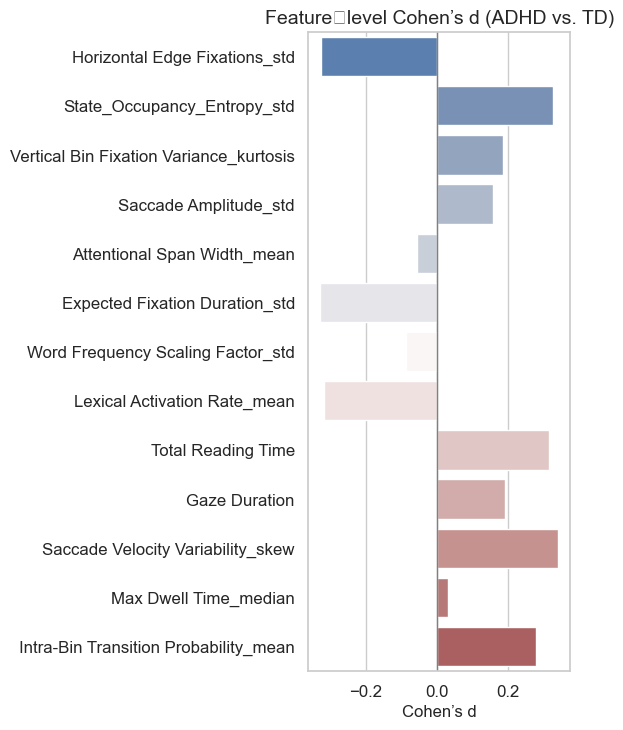

2025-05-10 00:55:36,337 INFO Group‐level discrimination:
         name      U        p         d    p_fdr  significant
       Markov 1390.0 0.336206  0.196503 0.336206        False
        SWIFT 1014.0 0.104484 -0.340909 0.156726        False
Complementary 1522.0 0.061252  0.422745 0.156726        False


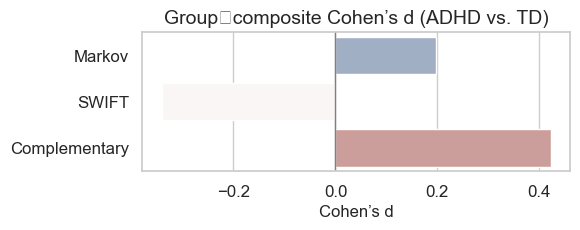

In [38]:
#!/usr/bin/env python3
"""
Feature‐ and group‐level discrimination analysis:
 - Mann–Whitney U tests (ADHD vs. TD)
 - FDR correction (Benjamini–Hochberg)
 - Cohen’s d effect sizes
 - Barplots of Cohen’s d with significance annotated
"""
import logging, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder

# --- Setup -----------------------------------------------------------------
warnings.filterwarnings("ignore")
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

# --- Constants -------------------------------------------------------------
DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")

FEATURES = [
  "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
    "Vertical Bin Fixation Variance_kurtosis", "Saccade Amplitude_std", 
    "Attentional Span Width_mean", "Expected Fixation Duration_std", "Word Frequency Scaling Factor_std", 'Lexical Activation Rate_mean',
     "Total Reading Time",'Gaze Duration',
    "Saccade Velocity Variability_skew", "Max Dwell Time_median",
    "Intra-Bin Transition Probability_mean", 

#‘KL Divergence’,Regression Transition Ratio, Sliding-window Transition Entropy, Word Difficulty Sensitivity

]
GROUPS = {
    "Markov": [
        "Horizontal Edge Fixations_std", "State_Occupancy_Entropy_std",
        "Vertical Bin Fixation Variance_kurtosis", "Intra-Bin Transition Probability_mean", "Max Dwell Time_median",
         
    ],
    "SWIFT": ["Attentional Span Width_mean", "Expected Fixation Duration_std", "Word Frequency Scaling Factor_std", 'Lexical Activation Rate_mean'],
    "Complementary": [
         "Total Reading Time",'Gaze Duration',
        "Saccade Velocity Variability_skew",
        "Saccade Amplitude_std", 
    ],
}

TARGET = "Group"  # assumes values {ADHD, TD}

# --- Helper functions -----------------------------------------------------
def cohens_d(x, y):
    """Compute pooled Cohen's d."""
    n1, n2 = len(x), len(y)
    s1, s2 = x.std(ddof=1), y.std(ddof=1)
    s_pool = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2) / (n1 + n2 - 2))
    return (x.mean() - y.mean()) / s_pool

def feature_discrimination(df, target_col, features, alpha=0.05):
    """
    For each feature:
      - Mann–Whitney U test
      - Cohen's d
      - FDR correction across features
    Returns a DataFrame with U, p, p_fdr, significant, d.
    """
    y = LabelEncoder().fit_transform(df[target_col])
    results = []
    for feat in features:
        x0 = df.loc[y==0, feat]
        x1 = df.loc[y==1, feat]
        u, p = mannwhitneyu(x0, x1, alternative="two-sided")
        d = cohens_d(x0, x1)
        results.append({"name": feat, "U": u, "p": p, "d": d})
    # FDR correction
    pvals = [r["p"] for r in results]
    reject, p_fdr, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    for r, pf, rej in zip(results, p_fdr, reject):
        r["p_fdr"] = pf
        r["significant"] = rej
    return pd.DataFrame(results)

def group_discrimination(df, target_col, groups, alpha=0.05):
    """
    For each group of features:
      - z-score each feature within the group
      - average them to a single composite per subject
      - Mann–Whitney U, Cohen's d
      - FDR correction across groups
    """
    y = LabelEncoder().fit_transform(df[target_col])
    results = []
    for grp, feats in groups.items():
        # z-score then average
        z = df[feats].apply(lambda col: (col - col.mean())/col.std(ddof=1))
        comp = z.mean(axis=1)
        x0, x1 = comp[y==0], comp[y==1]
        u, p = mannwhitneyu(x0, x1, alternative="two-sided")
        d = cohens_d(x0, x1)
        results.append({"name": grp, "U": u, "p": p, "d": d})
    # FDR
    pvals = [r["p"] for r in results]
    reject, p_fdr, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    for r, pf, rej in zip(results, p_fdr, reject):
        r["p_fdr"] = pf
        r["significant"] = rej
    return pd.DataFrame(results)

def plot_effect_sizes(df_stats, name_col, title, filename):
    """
    Barplot of Cohen's d, with '*' marking significant rows.
    """
    plt.figure(figsize=(6, len(df_stats)*0.5 + 1))
    sns.barplot(x="d", y=name_col, data=df_stats, palette="vlag", orient="h")
    plt.axvline(0, color="gray", linewidth=1)
    for i, row in df_stats.iterrows():
        if row["significant"]:
            plt.text(row["d"] + np.sign(row["d"])*0.02, i, "*",
                     va="center", fontsize=14, fontweight="bold")
    plt.title(title, fontsize=14)
    plt.xlabel("Cohen’s d", fontsize=12)
    plt.ylabel("")
    plt.tight_layout()
    plt.savefig(filename, dpi=300)
    plt.show()

# --- Main ------------------------------------------------------------------
def main():
    df = pd.read_csv(DATA_PATH)
    log.info(f"Loaded {len(df)} samples, {len(FEATURES)} features")

    # 1) Per‐feature discrimination
    feat_df = feature_discrimination(df, TARGET, FEATURES)
    log.info("Per‐feature discrimination:\n" + feat_df.to_string(index=False))
    plot_effect_sizes(feat_df, "name",
                      "Feature‐level Cohen’s d (ADHD vs. TD)",
                      "feature_effect_sizes.png")

    # 2) Group‐level discrimination
    grp_df = group_discrimination(df, TARGET, GROUPS)
    log.info("Group‐level discrimination:\n" + grp_df.to_string(index=False))
    plot_effect_sizes(grp_df, "name",
                      "Group‐composite Cohen’s d (ADHD vs. TD)",
                      "group_effect_sizes.png")

if __name__ == "__main__":
    main()


In [42]:
import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder

def compute_group_discrimination(df, target_col, groups, alpha=0.05):
    """
    For each named group of features:
      - aggregate (mean of z-scored features per subject)
      - Mann–Whitney U two-sided test
      - Cohen's d
      - FDR correction across the groups
    """
    # encode labels 0/1
    y = LabelEncoder().fit_transform(df[target_col])
    
    def cohens_d(x, y):
        n1, n2 = len(x), len(y)
        s1, s2 = x.std(ddof=1), y.std(ddof=1)
        sp = np.sqrt(((n1-1)*s1**2 + (n2-1)*s2**2)/(n1+n2-2))
        return (x.mean() - y.mean())/sp

    results = []
    for name, feats in groups.items():
        # z-score each feature, then average across features → one score per subject
        agg = (
            df[feats]
            .apply(lambda col: (col - col.mean())/col.std(ddof=1), axis=0)
            .mean(axis=1)
        )
        x0, x1 = agg[y==0], agg[y==1]
        u_stat, p_val = mannwhitneyu(x0, x1, alternative="two-sided")
        d = cohens_d(x0, x1)
        results.append({"group": name, "U": u_stat, "p": p_val, "d": d})

    # FDR correction over all groups
    pvals = [r["p"] for r in results]
    # correct unpacking: first element is reject array, second is corrected p-values
    reject, p_fdr, _, _ = multipletests(pvals, alpha=alpha, method="fdr_bh")
    
    # attach back to results
    for r, pf, rej in zip(results, p_fdr, reject):
        r["p_fdr"] = pf
        r["reject"] = bool(rej)

    # display
    res_df = pd.DataFrame(results)[["group", "U", "p", "p_fdr", "reject", "d"]]
    print(res_df.to_string(index=False))
    return res_df

# --- USAGE EXAMPLE ---------------------------------------------------------

if __name__ == "__main__":
    DATA_PATH = "D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv"
    TARGET    = "Group"
    GROUPS    = {
        "Markov": ["Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
                   "Fixation_Deviation_Variance_kurtosis_func",
                   "Self_Transition_Ratio_Count_mean"],
        "SWIFT":  ["nu_mean", "mt_std", "beta_std", "r_mean"],
        "Complementary": [
            "totaltime_exp", "gazedur_exp",
            "std_saccade_velocity_skew",
            "mean_saccade_amplitude_std"
        ],
    }

    df = pd.read_csv(DATA_PATH)
    compute_group_discrimination(df, TARGET, GROUPS)


KeyError: "['Frac_Extreme_X_std', 'Fixation_Deviation_Variance_kurtosis_func', 'Self_Transition_Ratio_Count_mean'] not in index"

In [11]:
#!/usr/bin/env python3
"""
Feature‐level discrimination:
 - Mann–Whitney U test (two‐sided) for each feature
 - Benjamini–Hochberg FDR correction (α=0.05)
 - Cohen’s d effect‐size
"""
import logging
from pathlib import Path

import numpy as np
import pandas as pd
from scipy.stats import mannwhitneyu
from statsmodels.stats.multitest import multipletests
from sklearn.preprocessing import LabelEncoder

# --- Setup -----------------------------------------------------------------
logging.basicConfig(level=logging.INFO, format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

# --- Constants -------------------------------------------------------------
DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")
FEATURES = [
    "Frac_Extreme_X_std", "State_Occupancy_Entropy_std", "Fixation_Deviation_Variance_kurtosis_func",
    "mean_saccade_amplitude_std", "nu_mean", "mt_std", "beta_std", "r_mean",
    "totaltime_exp", "gazedur_exp", "std_saccade_velocity_skew",
    "Max_Dwell_Time_median", "Self_Transition_Ratio_Count_mean"
]
TARGET = "Group"  # assume values like 'ADHD' / 'TD'

# --- Utility functions ----------------------------------------------------
def cohens_d(x, y):
    """Compute Cohen's d for two independent samples."""
    n1, n2 = len(x), len(y)
    s1, s2 = x.std(ddof=1), y.std(ddof=1)
    # pooled standard deviation
    s_pooled = np.sqrt(((n1 - 1)*s1**2 + (n2 - 1)*s2**2) / (n1 + n2 - 2))
    return (x.mean() - y.mean()) / s_pooled

# --- Main -----------------------------------------------------------------
def main():
    log.info("Loading data from %s", DATA_PATH)
    df = pd.read_csv(DATA_PATH)
    
    # encode target to 0/1
    le = LabelEncoder()
    y = le.fit_transform(df[TARGET])
    classes = le.classes_
    log.info("Label mapping: %s", dict(enumerate(classes)))
    
    p_vals    = []
    stat_vals = []
    effect_ds = []
    
    # run Mann–Whitney U for each feature
    for feat in FEATURES:
        x_ADHD = df.loc[y==0, feat].values
        x_TD   = df.loc[y==1, feat].values
        stat, p = mannwhitneyu(x_ADHD, x_TD, alternative='two-sided')
        d = cohens_d(x_ADHD, x_TD)
        
        stat_vals.append(stat)
        p_vals.append(p)
        effect_ds.append(d)
        
        log.info(f"{feat:30s}  U={stat:.1f}, p={p:.3f}, d={d:.3f}")
    
    # FDR correction
    reject, p_fdr, _, _ = multipletests(p_vals, alpha=0.05, method='fdr_bh')
    print("\nFeature |   U   |    p    |  p_FDR  |  Reject? | Cohen's d")
    print("-"*65)
    for feat, u, p, pf, rej, d in zip(FEATURES, stat_vals, p_vals, p_fdr, reject, effect_ds):
        print(f"{feat:30s} {u:6.1f}   {p:6.3f}   {pf:6.3f}   {str(rej):>7s}   {d:8.3f}")

if __name__ == "__main__":
    main()


2025-05-09 17:49:59,280 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-09 17:49:59,295 INFO Label mapping: {0: 'ADHD', 1: 'TD'}
2025-05-09 17:49:59,298 INFO Frac_Extreme_X_std              U=1045.0, p=0.159, d=-0.325
2025-05-09 17:49:59,301 INFO State_Occupancy_Entropy_std     U=1645.0, p=0.007, d=0.326
2025-05-09 17:49:59,304 INFO Fixation_Deviation_Variance_kurtosis_func  U=1456.0, p=0.157, d=0.185
2025-05-09 17:49:59,307 INFO mean_saccade_amplitude_std      U=1295.0, p=0.759, d=0.159
2025-05-09 17:49:59,310 INFO nu_mean                         U=1301.0, p=0.728, d=-0.056
2025-05-09 17:49:59,313 INFO mt_std                          U=1098.0, p=0.296, d=-0.328
2025-05-09 17:49:59,316 INFO beta_std                        U=1171.0, p=0.588, d=-0.088
2025-05-09 17:49:59,319 INFO r_mean                          U=1032.0, p=0.134, d=-0.317
2025-05-09 17:49:59,323 INFO totaltime_exp                   U=1465.0, p=0


Feature |   U   |    p    |  p_FDR  |  Reject? | Cohen's d
-----------------------------------------------------------------
Frac_Extreme_X_std             1045.0    0.159    0.344     False     -0.325
State_Occupancy_Entropy_std    1645.0    0.007    0.085     False      0.326
Fixation_Deviation_Variance_kurtosis_func 1456.0    0.157    0.344     False      0.185
mean_saccade_amplitude_std     1295.0    0.759    0.822     False      0.159
nu_mean                        1301.0    0.728    0.822     False     -0.056
mt_std                         1098.0    0.296    0.481     False     -0.328
beta_std                       1171.0    0.588    0.765     False     -0.088
r_mean                         1032.0    0.134    0.344     False     -0.317
totaltime_exp                  1465.0    0.139    0.344     False      0.315
gazedur_exp                    1338.0    0.546    0.765     False      0.190
std_saccade_velocity_skew      1482.0    0.111    0.344     False      0.341
Max_Dwell_Time_m

2025-05-09 18:50:55,469 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-09 18:50:55,490 INFO Label mapping: {0: 'ADHD', 1: 'TD'}
2025-05-09 18:50:58,859 INFO Fold 1: AUC=0.800
2025-05-09 18:51:02,248 INFO Fold 2: AUC=0.900
2025-05-09 18:51:02,704 INFO Fold 3: AUC=0.850
2025-05-09 18:51:03,340 INFO Fold 4: AUC=0.770
2025-05-09 18:51:04,091 INFO Fold 5: AUC=0.940
2025-05-09 18:51:04,093 INFO Nested CV AUC: 0.852 (95% CI [0.773, 0.936])
2025-05-09 18:51:05,798 INFO Bootstrap AUC CI: 95% CI [0.772, 0.920]
2025-05-09 18:51:07,221 INFO AUC label-permutation p-value: 0.000


              precision    recall  f1-score   support

        ADHD       0.78      0.78      0.78        50
          TD       0.78      0.78      0.78        50

    accuracy                           0.78       100
   macro avg       0.78      0.78      0.78       100
weighted avg       0.78      0.78      0.78       100



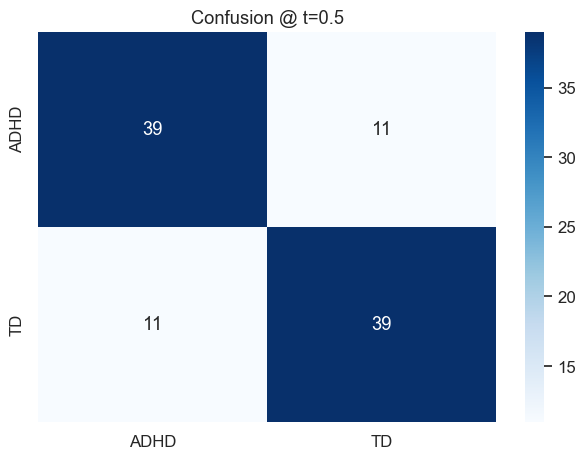

Feature label-permutation Δmean and p-values (FDR‐adjusted):
  Frac_Extreme_X_std             Δmean=-0.001, p=0.105, p_fdr=0.254 
  State_Occupancy_Entropy_std    Δmean= 0.014, p=0.101, p_fdr=0.254 
  Fixation_Deviation_Variance_kurtosis_func Δmean= 1.097, p=0.358, p_fdr=0.517 
  mean_saccade_amplitude_std     Δmean= 2.176, p=0.447, p_fdr=0.581 
  nu_mean                        Δmean=-0.004, p=0.781, p_fdr=0.847 
  mt_std                         Δmean=-0.680, p=0.113, p_fdr=0.254 
  beta_std                       Δmean=-0.002, p=0.666, p_fdr=0.787 
  r_mean                         Δmean=-0.570, p=0.116, p_fdr=0.254 
  totaltime_exp                  Δmean= 20.543, p=0.117, p_fdr=0.254 
  gazedur_exp                    Δmean= 9.258, p=0.356, p_fdr=0.517 
  std_saccade_velocity_skew      Δmean= 0.194, p=0.094, p_fdr=0.254 
  Max_Dwell_Time_median          Δmean= 0.020, p=1.000, p_fdr=1.000 
  Self_Transition_Ratio_Count_mean Δmean= 0.015, p=0.165, p_fdr=0.307 
  * indicates p_fdr < 0.05



  0%|          | 0/100 [00:00<?, ?it/s]

2025-05-09 18:51:20,021 INFO num_full_subsets = 1
2025-05-09 18:51:20,023 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-09 18:51:20,024 INFO num_paired_subset_sizes = 6
2025-05-09 18:51:20,030 INFO weight_left = 0.6508991990327944
2025-05-09 18:51:20,062 INFO np.sum(w_aug) = 13.000000000000002
2025-05-09 18:51:20,063 INFO np.sum(self.kernelWeights) = 1.0
2025-05-09 18:51:20,067 INFO phi = array([-0.08007291,  0.10134715, -0.03858429, -0.01107195,  0.02567148,
        0.        , -0.2111401 ,  0.08210665,  0.0381031 ,  0.        ,
       -0.02331848,  0.02506828,  0.        ])
2025-05-09 18:51:20,074 INFO num_full_subsets = 1
2025-05-09 18:51:20,075 INFO remaining_weight_vector = array([0.29254702, 0.21453448, 0.17877873, 0.16090086, 0.15323891])
2025-05-09 18:51:20,076 INFO num_paired_subset_sizes = 6
2025-05-09 18:51:20,082 INFO weight_left = 0.6508991990327944
2025-05-09 18:51:20,122 INFO np.sum(w_aug) = 13.000000000000002


SHAP mean|value| (mean±95% CI):
  Frac_Extreme_X_std            0.043[0.036,0.050]
  State_Occupancy_Entropy_std   0.036[0.029,0.042]
  Fixation_Deviation_Variance_kurtosis_func0.049[0.041,0.055]
  mean_saccade_amplitude_std    0.018[0.015,0.022]
  nu_mean                       0.044[0.036,0.054]
  mt_std                        0.047[0.039,0.055]
  beta_std                      0.094[0.082,0.108]
  r_mean                        0.082[0.072,0.093]
  totaltime_exp                 0.130[0.115,0.148]
  gazedur_exp                   0.132[0.116,0.153]
  std_saccade_velocity_skew     0.006[0.004,0.008]
  Max_Dwell_Time_median         0.052[0.045,0.059]
  Self_Transition_Ratio_Count_mean0.040[0.034,0.047]

SHAP group-level |mean| summaries (95% CI):
  Markov         0.219[0.205,0.234]
  SWIFT          0.268[0.246,0.291]
  Complementary  0.286[0.255,0.319]



In [18]:
import logging, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import shap
from statsmodels.stats.multitest import multipletests

from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import (
    roc_curve, auc, classification_report,
    confusion_matrix, roc_auc_score
)
from sklearn.inspection import permutation_importance

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

from joblib import Parallel, delayed
import joblib

# --- Setup -----------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

# --- Constants -------------------------------------------------------------
DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")
FEATURES = [
    "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
    "Fixation_Deviation_Variance_kurtosis_func", "mean_saccade_amplitude_std", 
    "nu_mean", "mt_std", "beta_std", 'r_mean',
     "totaltime_exp",'gazedur_exp',
    "std_saccade_velocity_skew", "Max_Dwell_Time_median",
    "Self_Transition_Ratio_Count_mean", 
]
GROUPS = {
    "Markov": [
        "Frac_Extreme_X_std", "State_Occupancy_Entropy_std",
        "Fixation_Deviation_Variance_kurtosis_func", "Self_Transition_Ratio_Count_mean", "Max_Dwell_Time_median",
         
    ],
    "SWIFT": ["nu_mean",  "mt_std", "beta_std", 'r_mean'],
    "Complementary": [
         "totaltime_exp",'gazedur_exp',
        "std_saccade_velocity_skew",
        "mean_saccade_amplitude_std",
    ],
}
TARGET = "Group"
RANDOM_STATE = 42
OUT_MODEL = "svm_pipeline_full_auc_tuned.pkl"

# --- Data utilities --------------------------------------------------------
def load_df(path: Path):
    log.info("Loading data from %s", path)
    return pd.read_csv(path)

# --- Pipeline builder ------------------------------------------------------
def build_pipeline(with_smote=True):
    steps = [
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
    ]
    if with_smote:
        steps.append(("smote", SMOTE(random_state=RANDOM_STATE)))
    steps.append((
        "clf",
        SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE)
    ))
    return Pipeline(steps)

# --- Permutation helpers --------------------------------------------------
def permuted_auc(seed, y_true, y_score):
    rng = np.random.RandomState(seed)
    y_perm = rng.permutation(y_true)
    return roc_auc_score(y_perm, y_score)

def label_permutation_feature(seed, X_feat, y):
    rng = np.random.RandomState(seed)
    y_perm = rng.permutation(y)
    return X_feat[y_perm==0].mean() - X_feat[y_perm==1].mean()

# --- Nested CV & Tests -----------------------------------------------------
def nested_cv_evaluate(X, y, le):
    outer = StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(
        build_pipeline(),
        param_grid={
            "clf__kernel": ["linear"],
            "clf__C": [1,10,100],
            "clf__gamma": ["scale"]
        },
        scoring="roc_auc",  # optimize AUC directly
        cv=inner,
        n_jobs=-1,
        refit=True
    )

    all_probs = np.zeros(len(y))
    aucs = []
    for fold, (tr, te) in enumerate(outer.split(X, y), start=1):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:, 1]
        all_probs[te] = probs

        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_auc = auc(fpr, tpr)
        aucs.append(fold_auc)
        log.info(f"Fold {fold}: AUC={fold_auc:.3f}")

    mean_auc = np.mean(aucs)
    ci_auc = np.percentile(aucs, [2.5, 97.5])
    log.info(f"Nested CV AUC: {mean_auc:.3f} (95% CI [{ci_auc[0]:.3f}, {ci_auc[1]:.3f}])")

    # bootstrap CI on overall AUC
    B = 1000
    rng = np.random.RandomState(RANDOM_STATE)
    boots = [
        roc_auc_score(y[idx], all_probs[idx])
        for idx in (rng.choice(len(y), len(y), replace=True) for _ in range(B))
    ]
    lo, hi = np.percentile(boots, [2.5, 97.5])
    log.info(f"Bootstrap AUC CI: 95% CI [{lo:.3f}, {hi:.3f}]")

    # label-permutation p-value
    n_perms = 5000
    nulls = Parallel(n_jobs=-1)(
        delayed(permuted_auc)(s, y, all_probs) for s in range(n_perms)
    )
    pval = np.mean(nulls >= mean_auc)
    log.info(f"AUC label-permutation p-value: {pval:.3f}")

    # classification report & confusion matrix
    preds = (all_probs >= 0.5).astype(int)
    print(classification_report(y, preds, target_names=le.classes_))
    cm = confusion_matrix(y, preds)
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
                xticklabels=le.classes_, yticklabels=le.classes_)
    plt.title("Confusion @ t=0.5")
    plt.tight_layout()
    plt.show()

    # retrain on full data
    grid.fit(X, y)
    return grid.best_estimator_

# --- Feature label-permutation tests ---------------------------------------
def compute_label_permutation_features(X, y):
    n_perms = 5000
    obs_diffs = []
    pvals = []

    # compute observed difference & nulls
    for i, feat in enumerate(FEATURES):
        Xf = X[:, i]
        obs = Xf[y==0].mean() - Xf[y==1].mean()
        nulls = Parallel(n_jobs=-1)(
            delayed(label_permutation_feature)(s, Xf, y)
            for s in range(n_perms)
        )
        p = np.mean(np.abs(nulls) >= np.abs(obs))
        obs_diffs.append(obs)
        pvals.append(p)

    # FDR correction
    reject, pvals_fdr, _, _ = multipletests(pvals, alpha=0.05, method="fdr_bh")

    # report
    print("Feature label-permutation Δmean and p-values (FDR‐adjusted):")
    for feat, obs, p, pfdr, sig in zip(FEATURES, obs_diffs, pvals, pvals_fdr, reject):
        star = "*" if sig else " "
        print(f"  {feat:30s} Δmean={obs: .3f}, p={p:.3f}, p_fdr={pfdr:.3f}{star}")
    print("  * indicates p_fdr < 0.05\n")

# --- Permutation importances & group ΔAUC -------------------------------
def compute_permutation_importance(pipe, X, y):
    # single train/test split
    tr, te = next(
        StratifiedKFold(5, shuffle=True, random_state=RANDOM_STATE)
        .split(X, y)
    )
    pipe.fit(X[tr], y[tr])

    imp = permutation_importance(
        pipe, X[te], y[te],
        n_repeats=30,  # more repeats for stability
        random_state=RANDOM_STATE,
        scoring="roc_auc"
    )

    m, sd = imp.importances_mean, imp.importances_std
    print("Feature ΔAUC (mean±std):")
    for i in m.argsort()[::-1]:
        print(f"  {FEATURES[i]:30s}{m[i]:.3f}±{sd[i]:.3f}")

    print("\nGroup ΔAUC (summed):")
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        print(f"  {g:15s}{m[idxs].sum():.3f}")
    print()

# --- SHAP with bootstrap CIs -----------------------------------------------
def compute_shap_importance(pipe, X):
    bg = shap.sample(X, min(50, len(X)), random_state=RANDOM_STATE)
    expl = shap.KernelExplainer(lambda d: pipe.predict_proba(d)[:,1], bg)
    shap_vals = expl.shap_values(X, nsamples=200)
    abs_shap = np.abs(shap_vals)

    # feature-level bootstrap CIs
    B = 500
    rng = np.random.RandomState(RANDOM_STATE+1)
    boot_feats = np.vstack([
        abs_shap[rng.choice(len(X), len(X), replace=True)].mean(axis=0)
        for _ in range(B)
    ])
    mean_feats = abs_shap.mean(axis=0)
    lo_feats, hi_feats = np.percentile(boot_feats, [2.5, 97.5], axis=0)

    print("SHAP mean|value| (mean±95% CI):")
    for i, name in enumerate(FEATURES):
        print(f"  {name:30s}{mean_feats[i]:.3f}[{lo_feats[i]:.3f},{hi_feats[i]:.3f}]")

    # group-level bootstrap CIs
    print("\nSHAP group-level |mean| summaries (95% CI):")
    for g, feats in GROUPS.items():
        idxs = [FEATURES.index(f) for f in feats]
        vals = abs_shap[:, idxs].sum(axis=1)
        boots = [
            vals[rng.choice(len(vals), len(vals), replace=True)].mean()
            for _ in range(B)
        ]
        lo, hi = np.percentile(boots, [2.5, 97.5])
        print(f"  {g:15s}{vals.mean():.3f}[{lo:.3f},{hi:.3f}]")
    print()

# --- Main ------------------------------------------------------------------
def main():
    df = load_df(DATA_PATH)
    le = LabelEncoder()
    X = df[FEATURES].values
    y = le.fit_transform(df[TARGET])

    log.info(f"Label mapping: {dict(enumerate(le.classes_))}")

    pipe = nested_cv_evaluate(X, y, le)
    compute_label_permutation_features(X, y)
    compute_permutation_importance(pipe, X, y)

    print("\nComputing SHAP values…")
    compute_shap_importance(pipe, X)

    joblib.dump({'pipeline': pipe}, OUT_MODEL)
    log.info(f"Saved pipeline → {OUT_MODEL}")

if __name__ == "__main__":
    main()

2025-05-09 17:56:13,911 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-09 17:56:14,874 INFO SWIFT: AUC=0.642 (95% CI [0.575,0.747])
2025-05-09 17:56:15,496 INFO Markov: AUC=0.715 (95% CI [0.566,0.843])
2025-05-09 17:56:18,082 INFO Hybrid: AUC=0.852 (95% CI [0.773,0.936])
2025-05-09 17:56:21,532 INFO SWIFT vs Markov: ΔAUC=-0.071 (95% CI [-0.213,0.076]), DeLong p=0.336
2025-05-09 17:56:24,961 INFO SWIFT vs Hybrid: ΔAUC=-0.220 (95% CI [-0.317,-0.122]), DeLong p=0.000
2025-05-09 17:56:28,444 INFO Markov vs Hybrid: ΔAUC=-0.149 (95% CI [-0.256,-0.051]), DeLong p=0.007


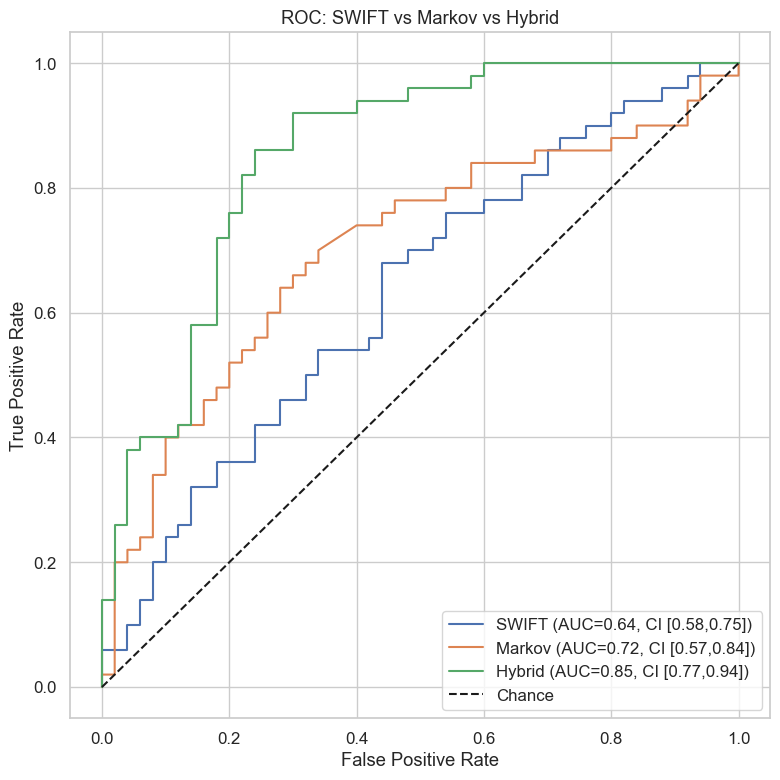

In [14]:
#!/usr/bin/env python3
"""
Compare Nested CV AUC across SWIFT, Markov, and Hybrid feature sets,
with:
 - fold-based CIs from single 5-fold nested CV
 - DeLong pairwise tests for AUC differences
 - Bootstrap CIs for ΔAUC
 - comparative ROC plot
"""
import logging, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
import scipy.stats as _stats

# --- DeLong implementation (adapted) ---------------------------------------
def compute_midrank(x):
    J = np.argsort(x)
    Z = x[J]
    N = len(x)
    T = np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T2 = np.empty(N, dtype=float)
    T2[J] = T + 1
    return T2


def fastDeLong(preds_sorted, m):
    # preds_sorted: 2 x N array, first row model1, second model2, sorted by decreasing label
    n = preds_sorted.shape[1] - m
    k = preds_sorted.shape[0]
    pos = preds_sorted[:, :m]
    neg = preds_sorted[:, m:]
    r_pos = np.vstack([compute_midrank(pos[r]) for r in range(k)])
    r_neg = np.vstack([compute_midrank(neg[r]) for r in range(k)])
    r_all = np.vstack([compute_midrank(preds_sorted[r]) for r in range(k)])
    aucs = (r_all[:, :m].sum(axis=1) / m - (m + 1) / 2) / n
    v01 = (r_all[:, :m] - r_pos) / n
    v10 = 1 - (r_all[:, m:] - r_neg) / m
    sx = np.cov(v01)
    sy = np.cov(v10)
    cov = sx / m + sy / n
    return aucs, cov


def delong_roc_test(y_true, pred1, pred2):
    y = np.array(y_true)
    order = np.argsort(-y)
    m = int(y.sum())
    # stack preds and sort columns
    stacked = np.vstack((pred1, pred2))[:, order]
    aucs, cov = fastDeLong(stacked, m)
    diff = abs(aucs[0] - aucs[1])
    l = np.array([[1, -1]])
    var = (l @ cov @ l.T)[0,0]
    z = diff / np.sqrt(var)
    p = 2 * (1 - _stats.norm.cdf(z))
    return p

# --- Setup -----------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

# --- Constants -------------------------------------------------------------
DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")
TARGET = "Group"
RANDOM_STATE = 42

# --- Feature sets ----------------------------------------------------------
FEATURE_GROUPS = {
    'SWIFT': ["nu_mean","mt_std","beta_std","r_mean"],
    'Markov': ["Frac_Extreme_X_std","State_Occupancy_Entropy_std",
               "Fixation_Deviation_Variance_kurtosis_func","Self_Transition_Ratio_Count_mean"],
    'Hybrid': ["nu_mean","mt_std","beta_std","r_mean",
               "Frac_Extreme_X_std","State_Occupancy_Entropy_std",
               "Fixation_Deviation_Variance_kurtosis_func","Self_Transition_Ratio_Count_mean",
               "totaltime_exp","gazedur_exp",
               "std_saccade_velocity_skew","Max_Dwell_Time_median","mean_saccade_amplitude_std"]
}

# --- Data utilities --------------------------------------------------------
def load_df(path: Path) -> pd.DataFrame:
    log.info("Loading data from %s", path)
    return pd.read_csv(path)

# --- Pipeline builder ------------------------------------------------------
def build_pipeline() -> Pipeline:
    return Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE))
    ])

# --- Nested CV -------------------------------------------------------------
def nested_cv_auc_single(X: np.ndarray, y: np.ndarray, pipe: Pipeline):
    """
    Returns list of fold AUCs and out-of-fold prediction probabilities.
    """
    outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(pipe,
                        param_grid={"clf__kernel":["linear"],"clf__C":[0.1,10,100],"clf__gamma":["scale"]},
                        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True)
    all_probs = np.zeros(len(y))
    fold_aucs = []
    for tr, te in outer.split(X, y):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:,1]
        all_probs[te] = probs
        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_aucs.append(auc(fpr, tpr))
    return fold_aucs, all_probs

# --- Bootstrap ΔAUC for paired CI ----------------------------------------
def bootstrap_delta_auc(y: np.ndarray, p1: np.ndarray, p2: np.ndarray, B: int=1000, alpha: float=0.05):
    """
    Compute bootstrap CI for ΔAUC = AUC1 - AUC2.
    Returns (obs_diff, (ci_low, ci_high)).
    """
    rng = np.random.RandomState(RANDOM_STATE)
    diffs = []
    for _ in range(B):
        idxs = rng.choice(len(y), len(y), replace=True)
        d = roc_auc_score(y[idxs], p1[idxs]) - roc_auc_score(y[idxs], p2[idxs])
        diffs.append(d)
    diffs = np.array(diffs)
    lower, upper = np.percentile(diffs, [100*alpha/2, 100*(1-alpha/2)])
    obs = roc_auc_score(y, p1) - roc_auc_score(y, p2)
    return obs, (lower, upper)

# --- Main ------------------------------------------------------------------
def main():
    df = load_df(DATA_PATH)
    le = LabelEncoder().fit(df[TARGET])
    y = le.transform(df[TARGET])
    pipe = build_pipeline()

    stats, all_probs = {}, {}
    for name, feats in FEATURE_GROUPS.items():
        X = df[feats].values
        fold_aucs, probs = nested_cv_auc_single(X, y, pipe)
        mean_auc = np.mean(fold_aucs)
        ci_low, ci_hi = np.percentile(fold_aucs, [2.5,97.5])
        stats[name] = (mean_auc, ci_low, ci_hi)
        all_probs[name] = probs
        log.info(f"{name}: AUC={mean_auc:.3f} (95% CI [{ci_low:.3f},{ci_hi:.3f}])")

    names = list(FEATURE_GROUPS.keys())
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            n1, n2 = names[i], names[j]
            p_del = delong_roc_test(y, all_probs[n1], all_probs[n2])
            obs_delta, (low, high) = bootstrap_delta_auc(y, all_probs[n1], all_probs[n2])
            log.info(f"{n1} vs {n2}: ΔAUC={obs_delta:.3f} (95% CI [{low:.3f},{high:.3f}]), DeLong p={p_del:.3f}")

    # Plot ROC
    plt.figure(figsize=(8,8))
    for name in names:
        m, low, high = stats[name]
        fpr, tpr, _ = roc_curve(y, all_probs[name])
        plt.plot(fpr, tpr, label=f"{name} (AUC={m:.2f}, CI [{low:.2f},{high:.2f}])")
    plt.plot([0,1],[0,1],'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('ROC: SWIFT vs Markov vs Hybrid')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


2025-05-09 17:57:26,208 INFO Loading data from D:\ACIT Master's Thesis\New data\Colab_eyetracking\stories\new_version03\merged_output100.csv
2025-05-09 17:57:27,198 INFO SWIFT: AUC=0.642 (95% CI [0.575,0.747])
2025-05-09 17:57:27,856 INFO Markov: AUC=0.715 (95% CI [0.566,0.843])
2025-05-09 17:57:30,484 INFO Hybrid: AUC=0.852 (95% CI [0.773,0.936])
2025-05-09 17:57:33,849 INFO SWIFT vs Markov: ΔAUC=-0.071 (95% CI [-0.213,0.076]), DeLong p=0.336
2025-05-09 17:57:37,084 INFO SWIFT vs Hybrid: ΔAUC=-0.220 (95% CI [-0.317,-0.122]), DeLong p=0.000
2025-05-09 17:57:40,324 INFO Markov vs Hybrid: ΔAUC=-0.149 (95% CI [-0.256,-0.051]), DeLong p=0.007


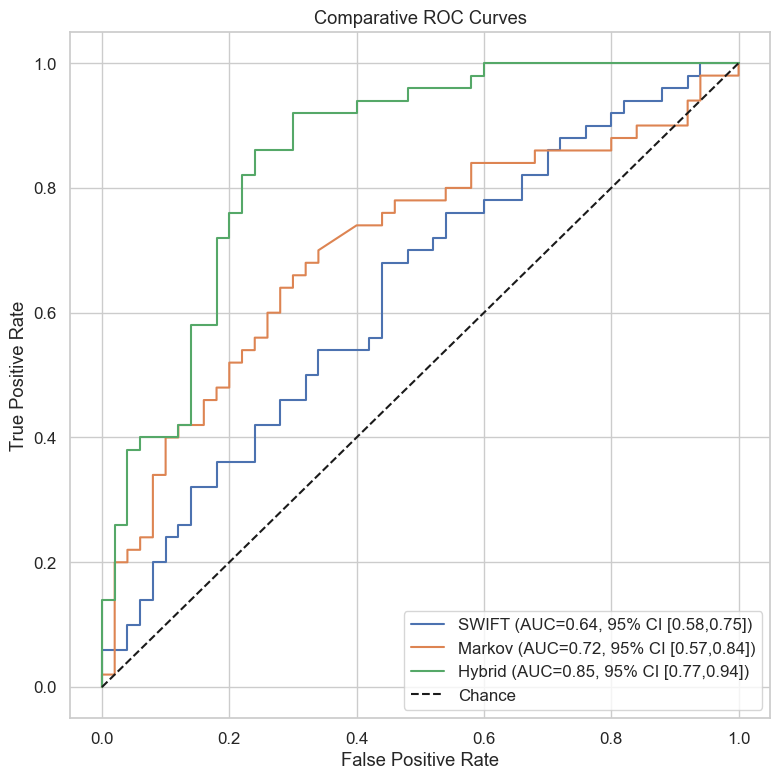

In [15]:
#!/usr/bin/env python3
"""
Compare Nested CV AUC across SWIFT, Markov, and Hybrid feature sets,
with:
 - fold-based CIs from single 5-fold nested CV
 - DeLong pairwise tests for AUC differences
 - Bootstrap CIs for ΔAUC
 - comparative ROC plot
"""
import logging, warnings
from pathlib import Path

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import PowerTransformer, LabelEncoder
from sklearn.svm import SVC
from sklearn.model_selection import StratifiedKFold, GridSearchCV
from sklearn.metrics import roc_curve, auc, roc_auc_score
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE

# --- DeLong implementation (from yandexdataschool/roc_comparison) ---
import numpy as _np
import scipy.stats as _stats

def compute_midrank(x):
    J = _np.argsort(x)
    Z = x[J]
    N = len(x)
    T = _np.zeros(N, dtype=float)
    i = 0
    while i < N:
        j = i
        while j < N and Z[j] == Z[i]:
            j += 1
        T[i:j] = 0.5 * (i + j - 1)
        i = j
    T2 = _np.empty(N, dtype=float)
    T2[J] = T + 1
    return T2

def fastDeLong(preds_sorted_transposed, label_1_count):
    m = label_1_count
    n = preds_sorted_transposed.shape[1] - m
    k = preds_sorted_transposed.shape[0]
    pos = preds_sorted_transposed[:, :m]
    neg = preds_sorted_transposed[:, m:]
    r_pos = _np.vstack([compute_midrank(pos[r]) for r in range(k)])
    r_neg = _np.vstack([compute_midrank(neg[r]) for r in range(k)])
    r_all = _np.vstack([compute_midrank(preds_sorted_transposed[r]) for r in range(k)])
    aucs = (r_all[:, :m].sum(axis=1) / m - (m + 1) / 2) / n
    v01 = (r_all[:, :m] - r_pos) / n
    v10 = 1 - (r_all[:, m:] - r_neg) / m
    sx = _np.cov(v01)
    sy = _np.cov(v10)
    cov = sx / m + sy / n
    return aucs, cov

def calc_pvalue(aucs, cov):
    l = _np.array([[1, -1]])
    diff = abs(aucs[0] - aucs[1])
    var = (l @ cov @ l.T)[0,0]
    z = diff / _np.sqrt(var)
    return 2 * (1 - _stats.norm.cdf(z))

def compute_ground_truth_statistics(y_true):
    assert set(_np.unique(y_true)) == {0,1}
    order = (-y_true).argsort()
    label_1_count = int(y_true.sum())
    return order, label_1_count

def delong_roc_test(y_true, y_pred1, y_pred2):
    order, m = compute_ground_truth_statistics(y_true)
    preds_sorted = _np.vstack((y_pred1, y_pred2))[:, order]
    aucs, cov = fastDeLong(preds_sorted, m)
    return calc_pvalue(aucs, cov)

# --- Setup -----------------------------------------------------------------
warnings.filterwarnings("ignore", category=FutureWarning)
warnings.filterwarnings("ignore", category=UserWarning)
logging.basicConfig(level=logging.INFO,
                    format="%(asctime)s %(levelname)s %(message)s")
log = logging.getLogger(__name__)

# --- Constants -------------------------------------------------------------
DATA_PATH = Path(r"D:/ACIT Master's Thesis/New data/Colab_eyetracking/stories/new_version03/merged_output100.csv")
TARGET = "Group"
RANDOM_STATE = 42

# --- Feature sets ----------------------------------------------------------
FEATURE_GROUPS = {
    'SWIFT': ["nu_mean","mt_std","beta_std","r_mean"],
    'Markov': ["Frac_Extreme_X_std","State_Occupancy_Entropy_std",
               "Fixation_Deviation_Variance_kurtosis_func","Self_Transition_Ratio_Count_mean"],
    'Hybrid': ["nu_mean","mt_std","beta_std","r_mean",
               "Frac_Extreme_X_std","State_Occupancy_Entropy_std",
               "Fixation_Deviation_Variance_kurtosis_func","Self_Transition_Ratio_Count_mean",
               "totaltime_exp","gazedur_exp",
               "std_saccade_velocity_skew","Max_Dwell_Time_median","mean_saccade_amplitude_std"]
}

# --- Data utilities --------------------------------------------------------
def load_df(path):
    log.info("Loading data from %s", path)
    return pd.read_csv(path)

# --- Pipeline builder ------------------------------------------------------
def build_pipeline():
    return Pipeline([
        ("imputer", SimpleImputer(strategy="mean")),
        ("scaler", PowerTransformer(method="yeo-johnson")),
        ("smote", SMOTE(random_state=RANDOM_STATE)),
        ("clf", SVC(probability=True, class_weight="balanced", random_state=RANDOM_STATE))
    ])

# --- Nested CV -------------------------------------------------------------
def nested_cv_auc_single(X, y, pipe):
    outer = StratifiedKFold(n_splits=5, shuffle=True, random_state=RANDOM_STATE)
    inner = StratifiedKFold(n_splits=3, shuffle=True, random_state=RANDOM_STATE)
    grid = GridSearchCV(pipe,
                        param_grid={"clf__kernel":["linear"],"clf__C":[0.1,10,100],"clf__gamma":["scale"]},
                        scoring="roc_auc", cv=inner, n_jobs=-1, refit=True)
    all_probs = np.zeros(len(y))
    fold_aucs = []
    for tr, te in outer.split(X, y):
        grid.fit(X[tr], y[tr])
        probs = grid.predict_proba(X[te])[:,1]
        all_probs[te] = probs
        fpr, tpr, _ = roc_curve(y[te], probs)
        fold_aucs.append(auc(fpr, tpr))
    return fold_aucs, all_probs

# --- Bootstrap ΔAUC for paired CI ----------------------------------------
def bootstrap_delta_auc(y, p1, p2, B=1000, alpha=0.05):
    rng = np.random.RandomState(RANDOM_STATE)
    diffs = []
    for _ in range(B):
        idxs = rng.choice(len(y), len(y), replace=True)
        d = roc_auc_score(y[idxs], p1[idxs]) - roc_auc_score(y[idxs], p2[idxs])
        diffs.append(d)
    diffs = np.array(diffs)
    lower, upper = np.percentile(diffs, [100*alpha/2, 100*(1-alpha/2)])
    obs = roc_auc_score(y, p1) - roc_auc_score(y, p2)
    return obs, (lower, upper)

# --- Main ------------------------------------------------------------------
def main():
    df = load_df(DATA_PATH)
    le = LabelEncoder().fit(df[TARGET])
    y = le.transform(df[TARGET])
    pipe = build_pipeline()

    stats = {}
    all_probs = {}
    for name, feats in FEATURE_GROUPS.items():
        X = df[feats].values
        fold_aucs, probs = nested_cv_auc_single(X, y, pipe)
        mean_auc = np.mean(fold_aucs)
        ci_low, ci_hi = np.percentile(fold_aucs, [2.5,97.5])
        stats[name] = (mean_auc, ci_low, ci_hi)
        all_probs[name] = probs
        log.info(f"{name}: AUC={mean_auc:.3f} (95% CI [{ci_low:.3f},{ci_hi:.3f}])")

    names = list(FEATURE_GROUPS.keys())
    for i in range(len(names)):
        for j in range(i+1, len(names)):
            n1, n2 = names[i], names[j]
            p_del = delong_roc_test(y, all_probs[n1], all_probs[n2])
            obs_delta, (ci_low_delta, ci_hi_delta) = bootstrap_delta_auc(y, all_probs[n1], all_probs[n2])
            log.info(
                f"{n1} vs {n2}: ΔAUC={obs_delta:.3f} (95% CI [{ci_low_delta:.3f},{ci_hi_delta:.3f}]), DeLong p={p_del:.3f}"
            )

    # Plot comparative ROC curves
    plt.figure(figsize=(8,8))
    for name in names:
        m, low, high = stats[name]
        fpr, tpr, _ = roc_curve(y, all_probs[name])
        plt.plot(fpr, tpr, label=f"{name} (AUC={m:.2f}, 95% CI [{low:.2f},{high:.2f}])")
    plt.plot([0,1],[0,1],'k--', label='Chance')
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Comparative ROC Curves')
    plt.legend(loc='lower right')
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()
